---

<h1>P7 EXPLORATORY DATA ANALYSIS<span class="tocSkip"></span></h1>
Lérys Granado - 09/2021

---

# Notes

## Objectives:

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

Votre mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.
Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

Spécifications du dashboard
Michaël vous a fourni un cahier des charges pour le dashboard interactif. Celui-ci devra a minima contenir les fonctionnalités suivantes :

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.
Livrables attendus
- Le dashboard interactif répondant au cahier des charges précisé ci-dessus.
- Un dossier sur un outil de versioning de code contenant :
- Le code de la modélisation (du prétraitement à la prédiction)
- Le code générant le dashboard
- Le code permettant de déployer le modèle sous forme d'API
- Une note méthodologique décrivant :
    - La méthodologie d'entraînement du modèle
    - La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation
    - L’interprétabilité du modèle
    - Les limites et les améliorations possibles


## Instruction for merging

<div>
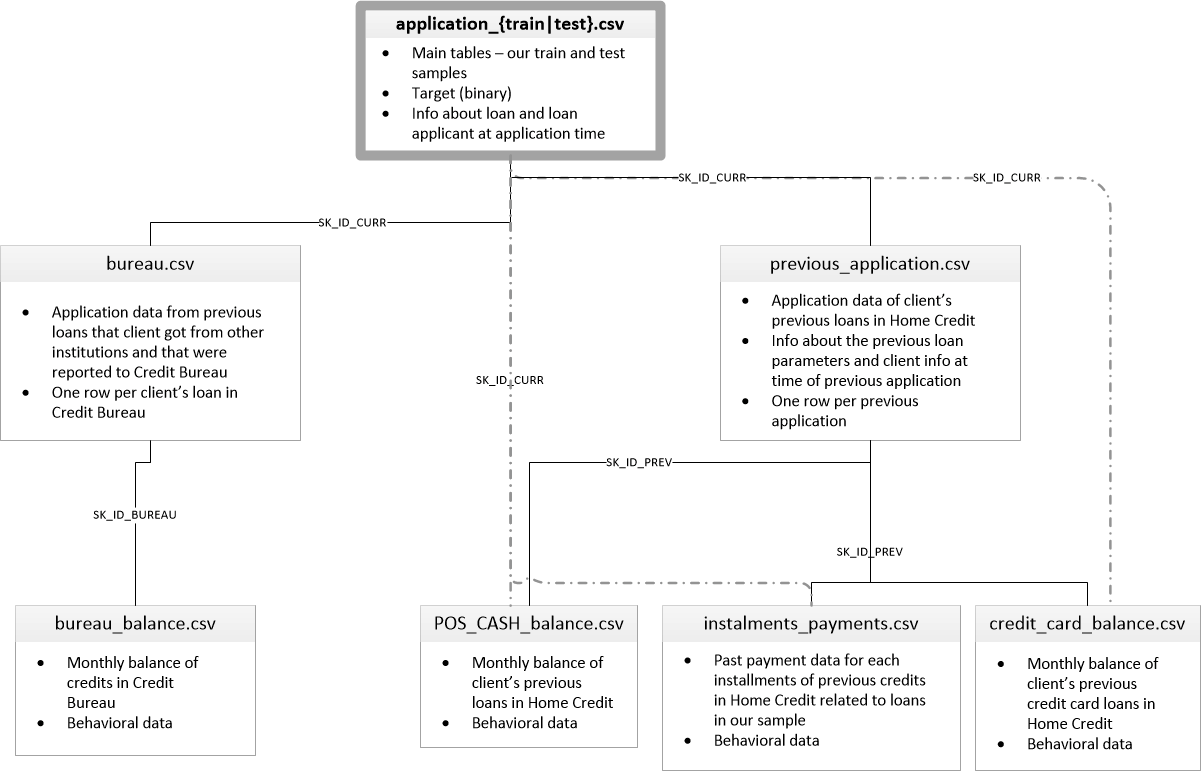
</div>

# Setting environment

In [2]:
import os
import gc
import csv
import zipfile
from urllib.request import urlretrieve
from IPython.display import display, HTML

import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
from matplotlib import rc
import matplotlib.pyplot as plt

%matplotlib inline

rc = {"font.family": "Arial",
      "font.size": 16,        
      "axes.labelsize": 16,
      "axes.titlesize": 16,
      "legend.fontsize": 14, 
      "xtick.labelsize": 14, 
      "ytick.labelsize": 14}


def my_colors(n=5):
    return [(sns.color_palette("viridis", 100)[i]) for i in np.linspace(0, 99, n, dtype=int)]


sns.set(font="Arial", rc=rc, palette=my_colors())
sns.set_style("ticks", {"axes.edgecolor": "k", 
                        "axes.linewidth": 0.8, 
                        "axes.grid": False,
                        "xtick.major.width": 0.8, 
                        "ytick.major.width": 0.8})

# Data import

- Raw data in csv file can be downloaded at "https://www.kaggle.com/c/home-credit-default-risk/data"

In [ ]:
# urlretrieve("https://s3-eu-west-1.amazonaws.com/static.oc-static.com \ 
# /prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+ \ 
# un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip", 
#             'Projet+Mise+en+prod+-+home-credit-default-risk.zip' 
#            )

# z = zipfile.ZipFile('Projet+Mise+en+prod+-+home-credit-default-risk.zip')
# z.extractall()

In [3]:
PATH = os.getcwd()
PATH += "\\input\\"

print(PATH)
print(os.listdir(PATH))

C:\Users\Lerys\Desktop\OC\P7\input\
['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


- Import only application data and descriptions

In [4]:
from red_size import reduce_memory_usage as red

f = PATH+'application_train.csv'

with open(f, 'r') as csvfile:  # Sniffing csv to find separator
    dialect = csv.Sniffer().sniff(csvfile.readline())
    sep = dialect.delimiter

df = pd.read_csv(f,
                 sep=sep,
                 low_memory=False,
                 verbose=False,
                 encoding='ISO-8859-1',
                 dtype={'Special': 'object'}
                 )

red(df, verbose=False)

In [4]:
f = PATH+'HomeCredit_columns_description.csv'
DESCRIPTOR = pd.read_csv(f, sep=sep, encoding='ISO-8859-1')
display(HTML(DESCRIPTOR.to_html()))

# Data form

## Data overview

df shape = (307511, 122)
NaN rate over whole df = 24%
df duplicates rate = 0%


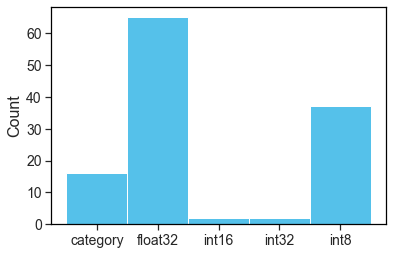

In [31]:
print(f'df shape = {df.shape}')
print(f'NaN rate over whole df = {df.isna().sum().sum()/df.size:.0%}')
print(f'df duplicates rate = {(len(df)-len(df.drop_duplicates()))/len(df):.0%}')

sns.histplot(df.dtypes.astype('string').sort_values(), color = '#1CADE4');
plt.show()

display(HTML(df.head(5).T.to_html()))

## Missing values

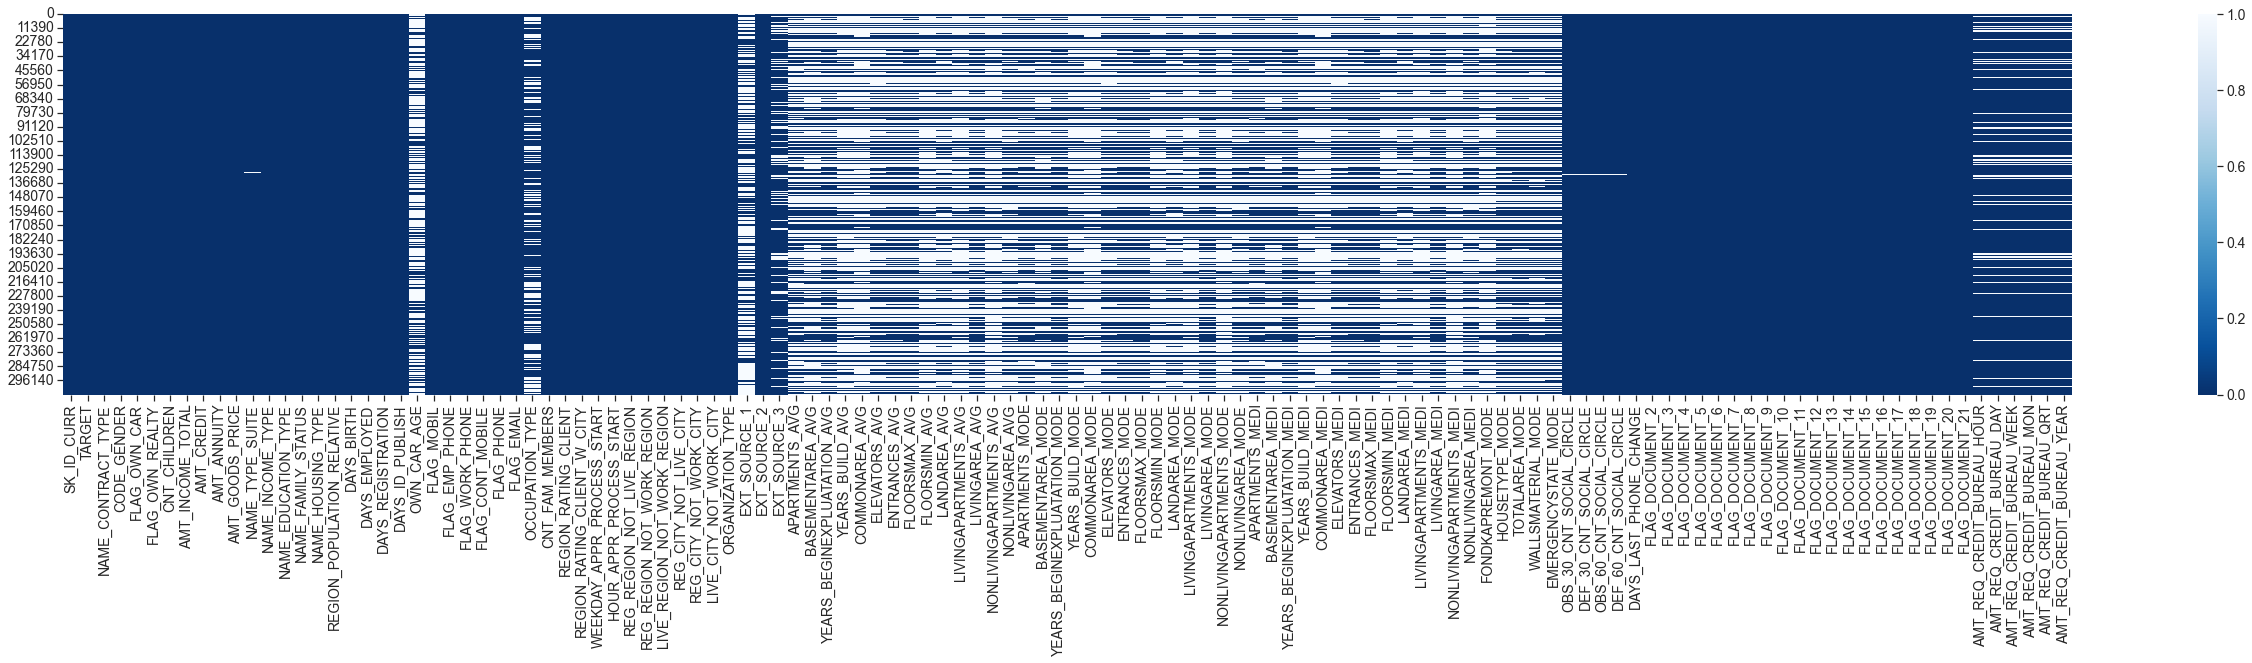

In [65]:
plt.figure(figsize=(45, 7))
sns.heatmap(df.isna(), cmap="Blues_r")
plt.show();

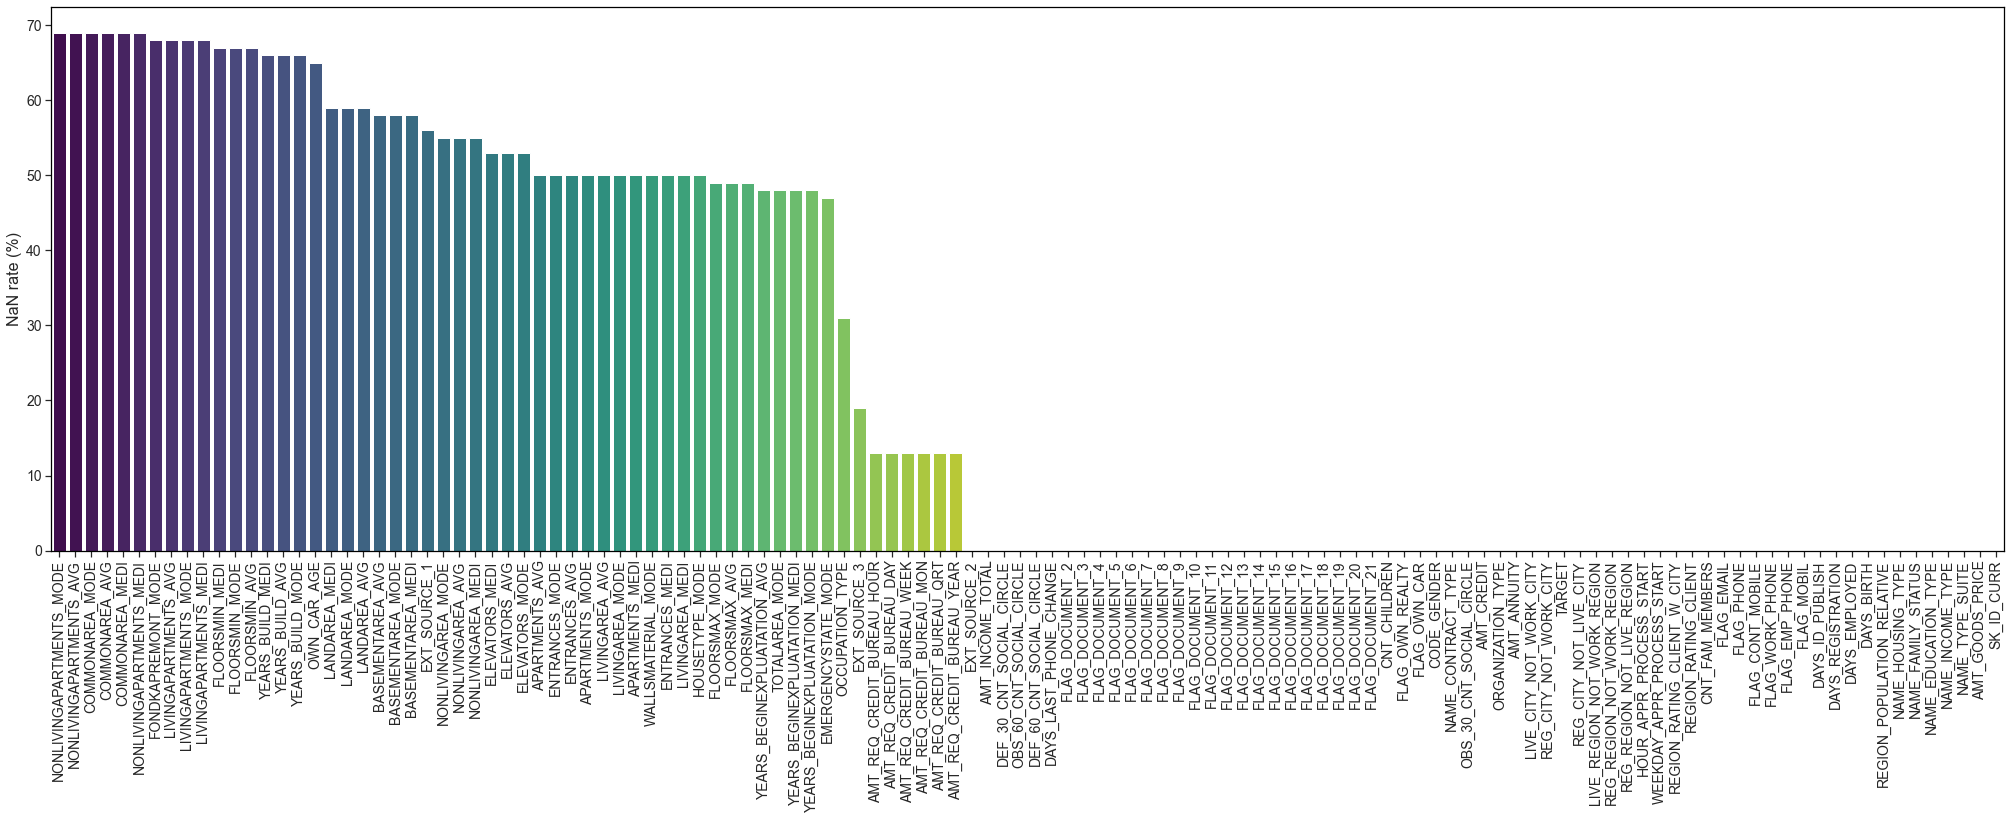

In [63]:
is_nan = (100*df.isna().sum()/len(df)).astype('int').sort_values(ascending=False)

plt.figure(figsize=(35,10))
sns.barplot(x=is_nan.index, y=is_nan, palette=my_colors(len(is_nan)//2))
plt.xticks(rotation = 90)
plt.ylabel('NaN rate (%)');

In [80]:
df_unpay = df[df.TARGET == 1]
df_pay = df[df.TARGET == 0]

In [81]:
print(df_unpay.shape)
print(df_pay.shape)

(24825, 122)
(282686, 122)


# Exploratory Data Analysis

## Target analysis

Unpayable represents 10% of payable. The classes are very unbalanced.

In [5]:
color_bg = ['dodgerblue', 'indianred']


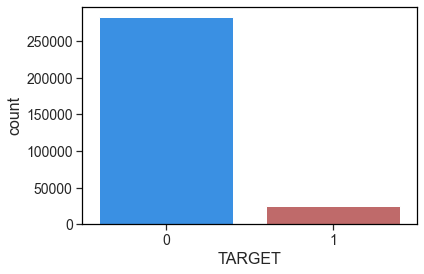

In [114]:
sns.countplot(x=df.TARGET, palette=color_bg);

## Target/num var relationships

In [6]:
num_col = df.select_dtypes(np.number).columns.to_list()
num_col.remove('TARGET')
len(num_col)

105

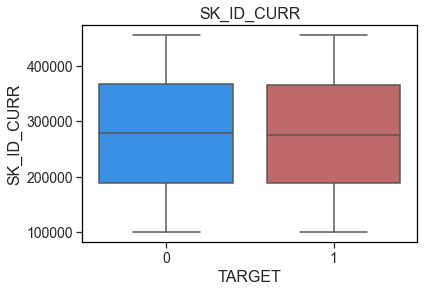

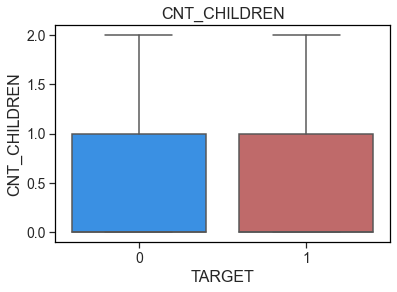

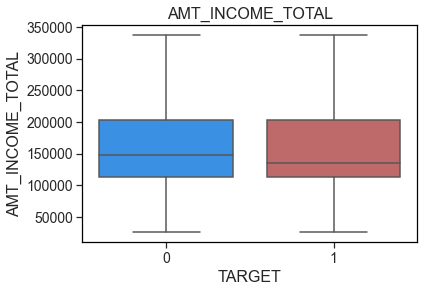

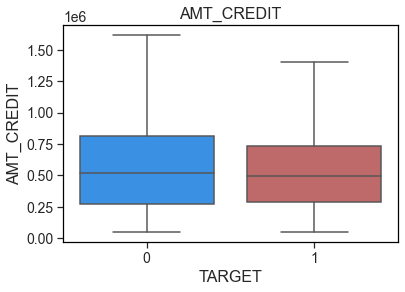

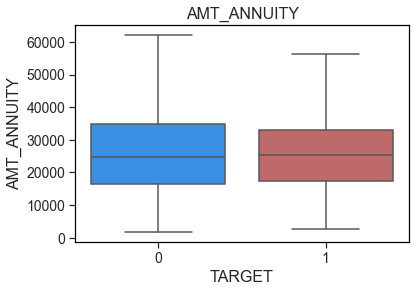

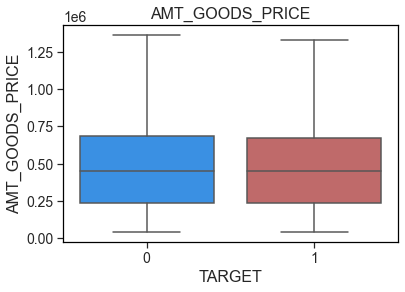

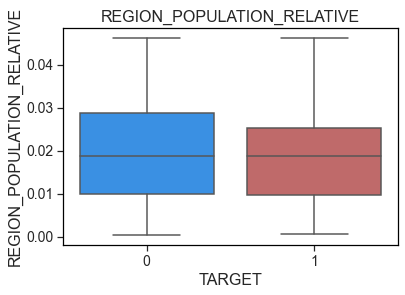

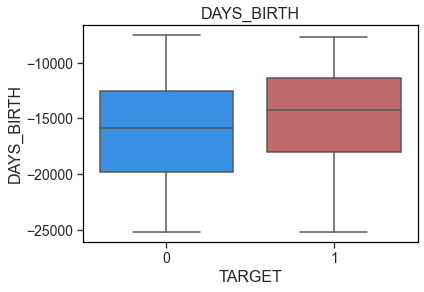

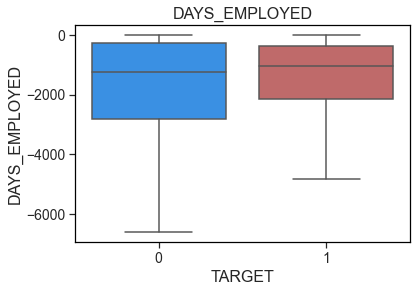

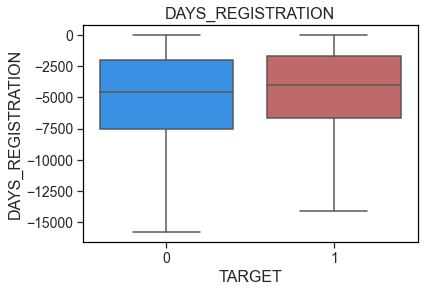

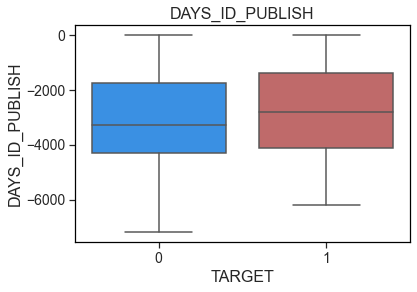

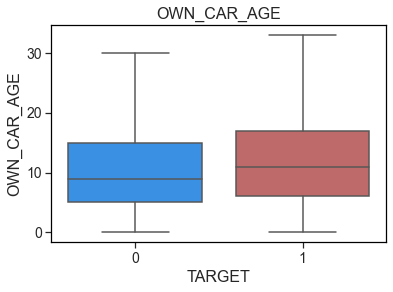

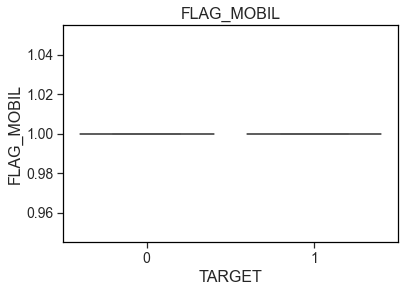

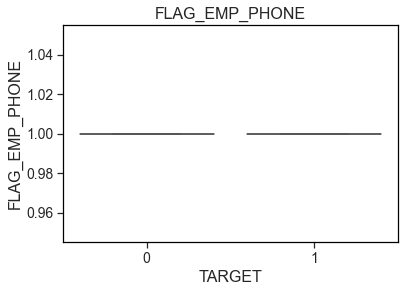

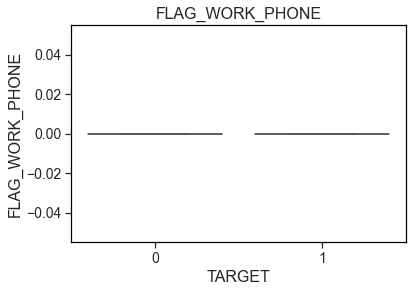

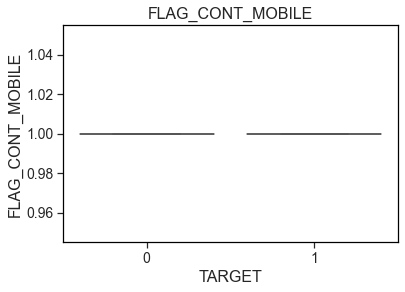

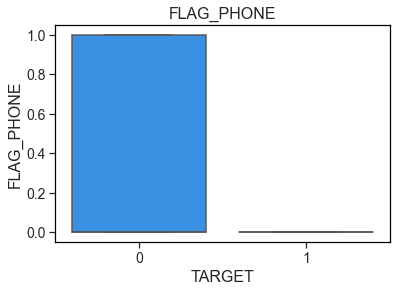

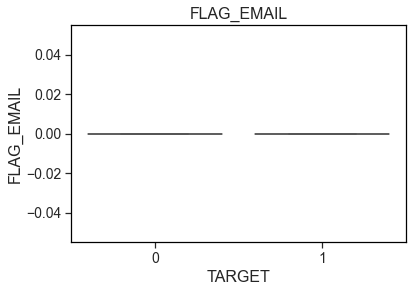

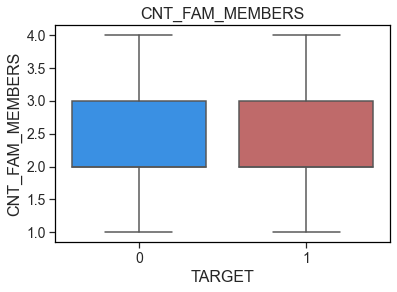

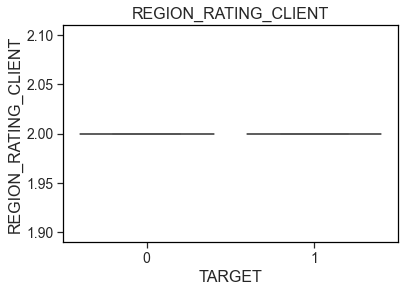

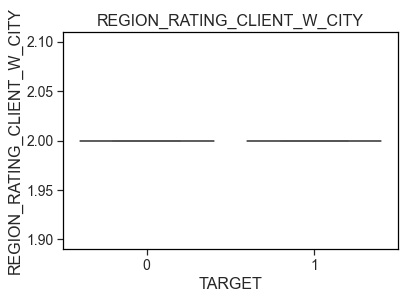

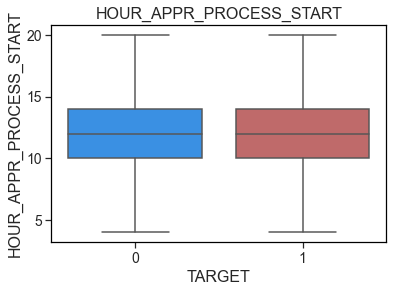

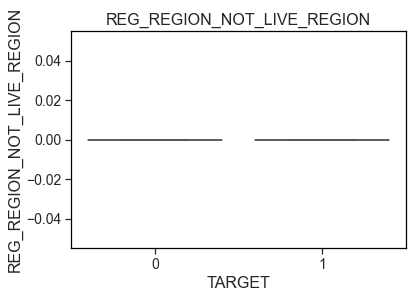

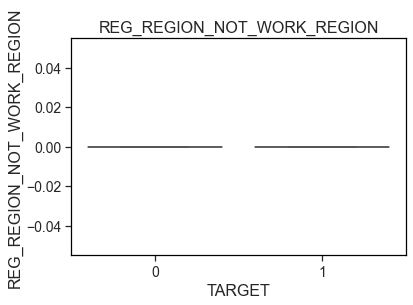

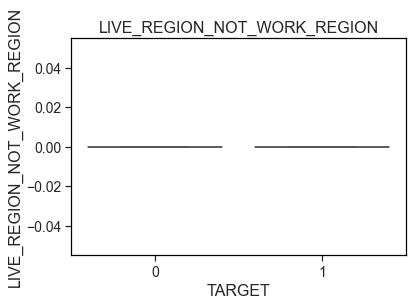

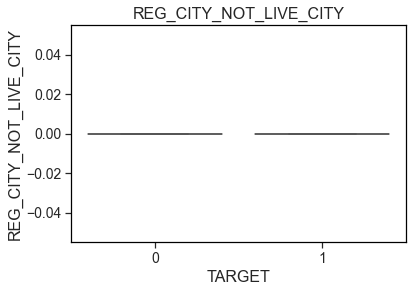

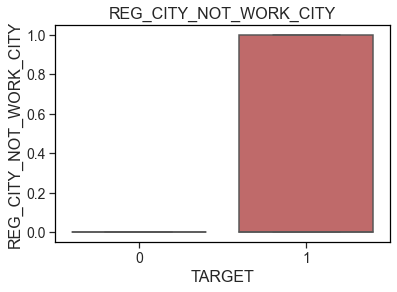

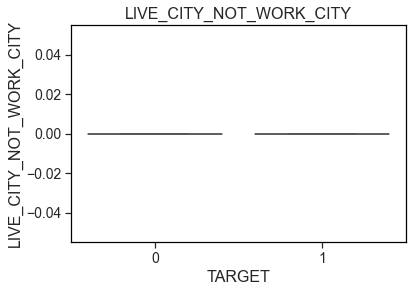

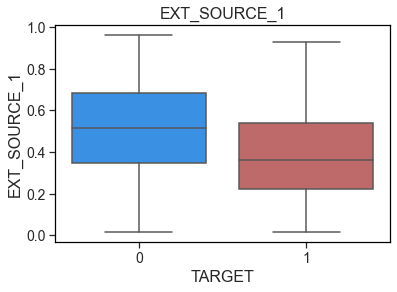

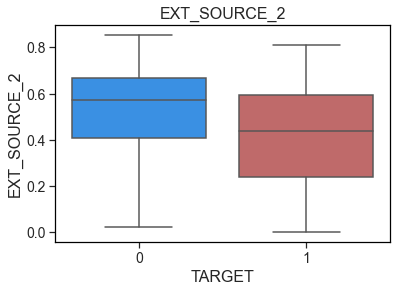

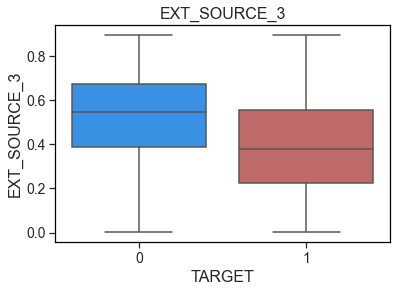

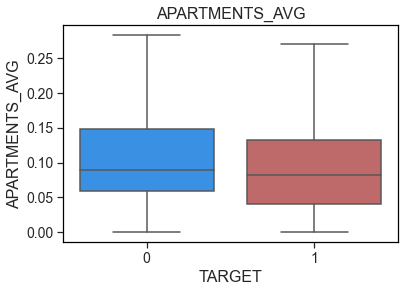

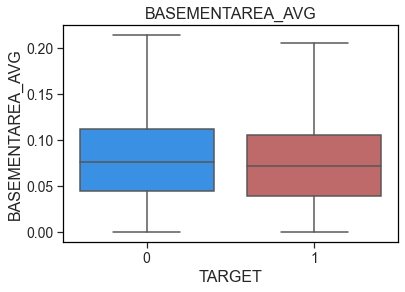

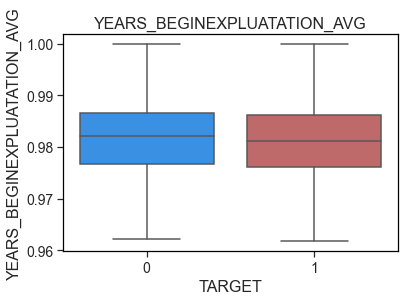

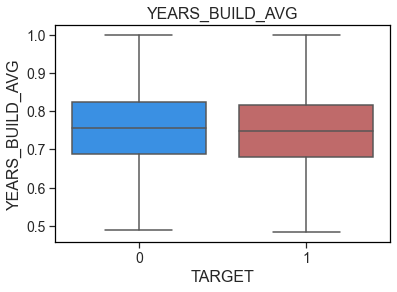

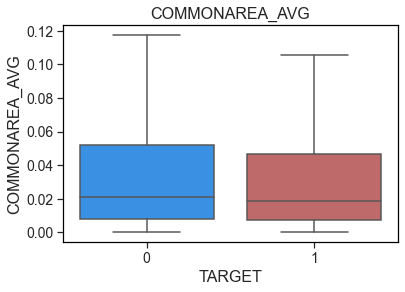

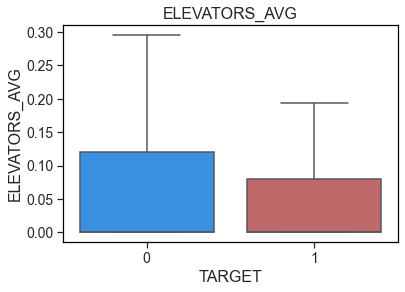

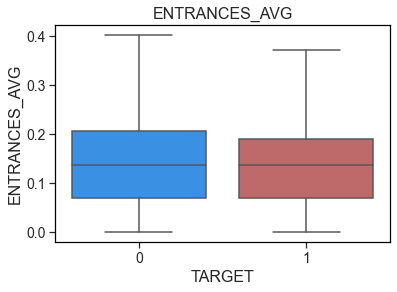

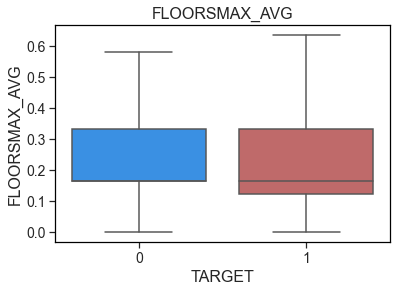

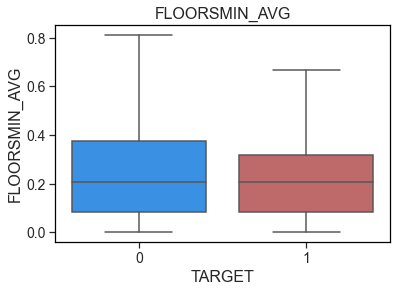

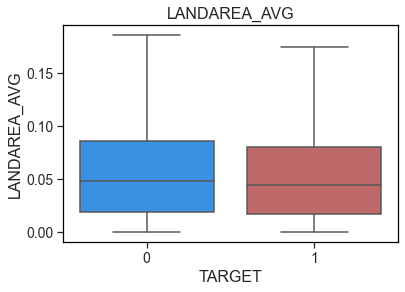

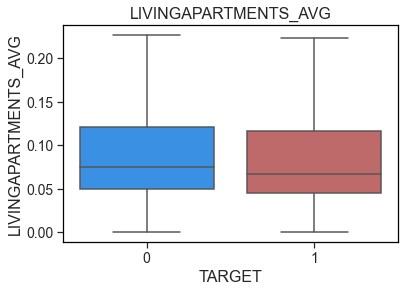

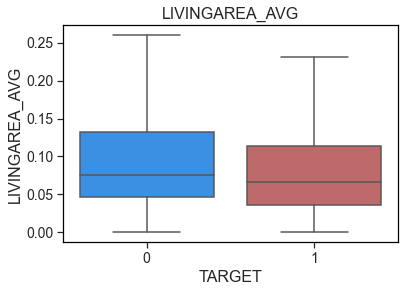

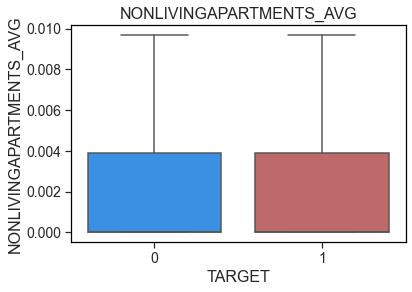

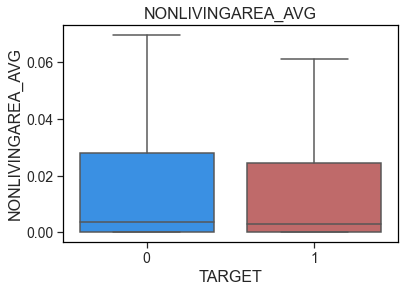

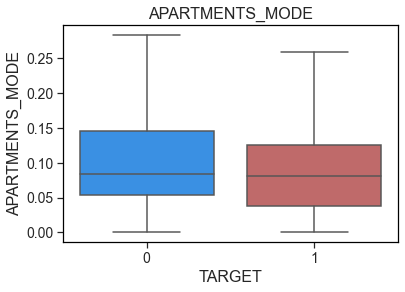

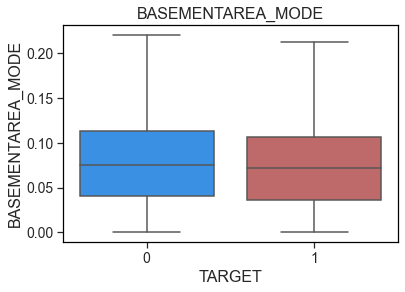

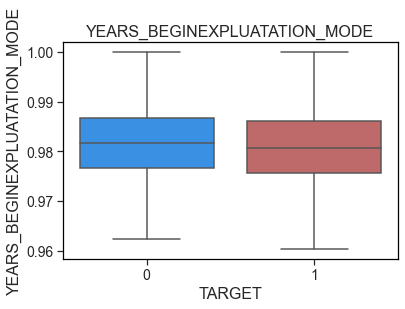

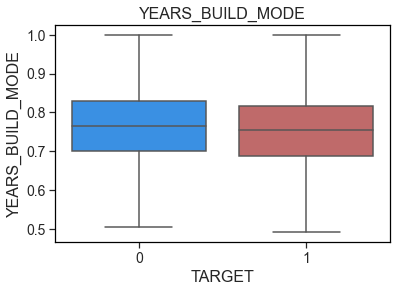

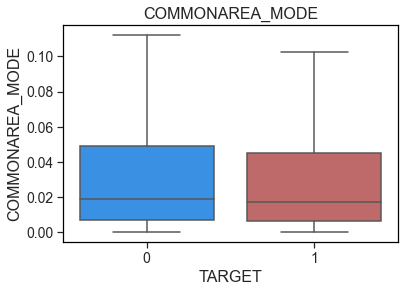

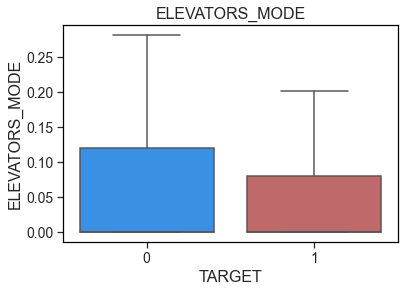

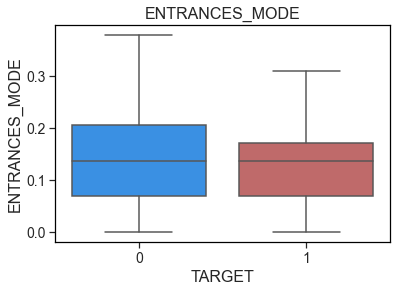

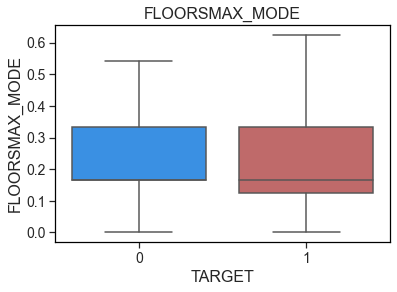

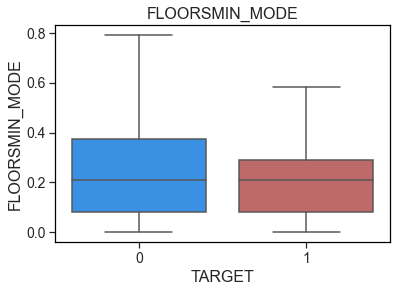

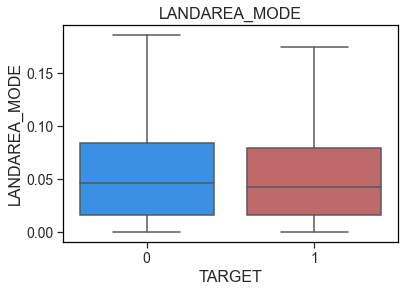

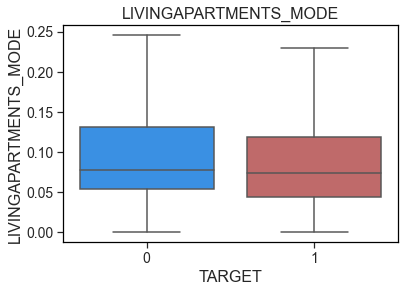

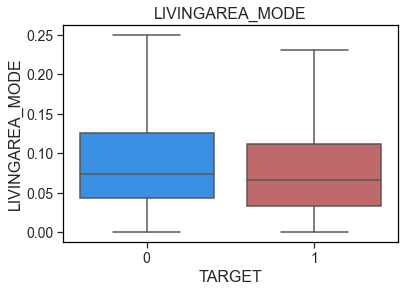

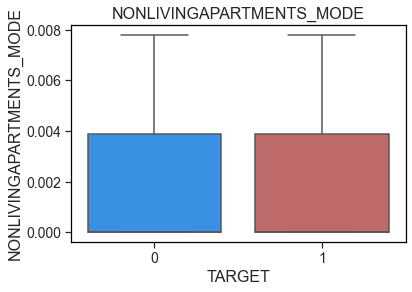

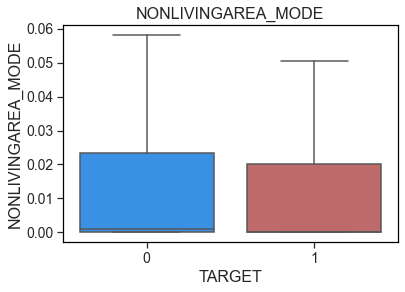

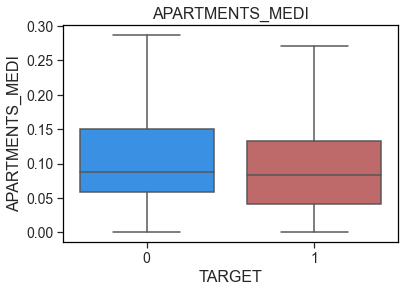

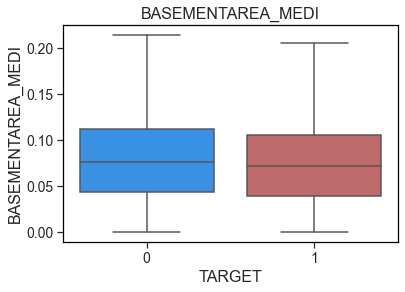

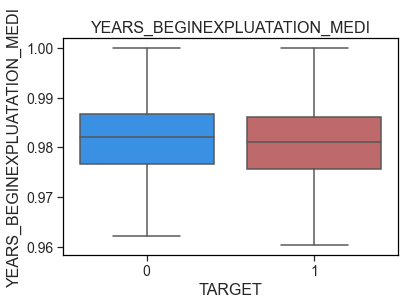

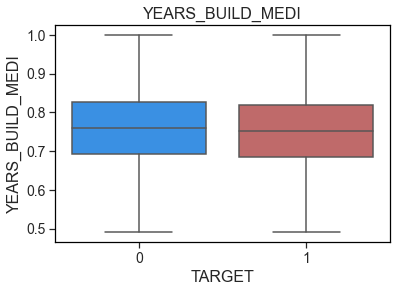

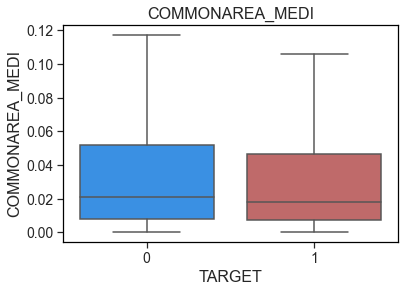

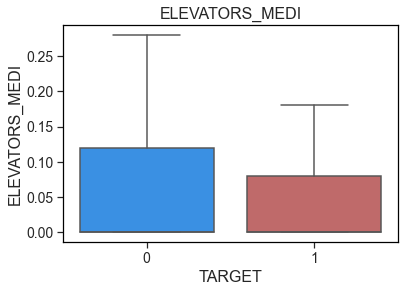

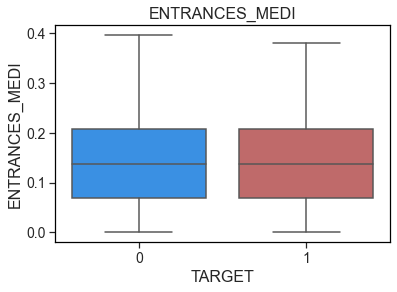

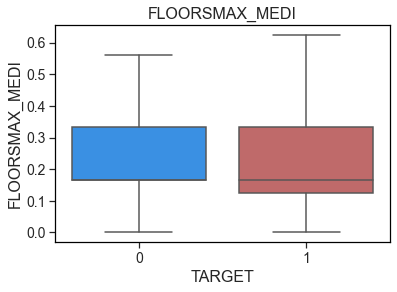

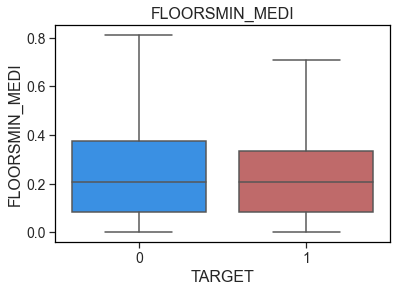

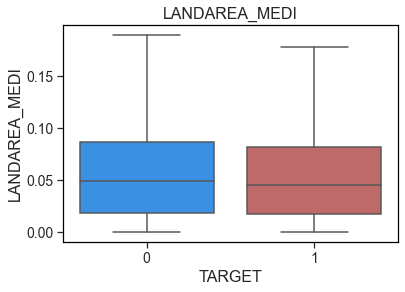

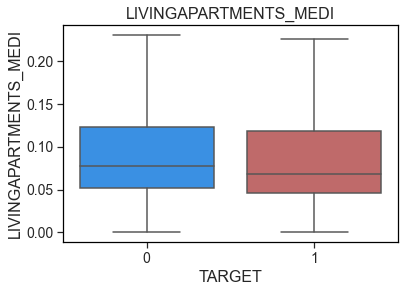

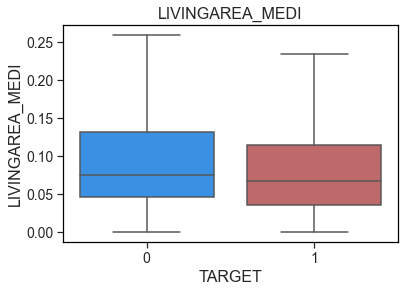

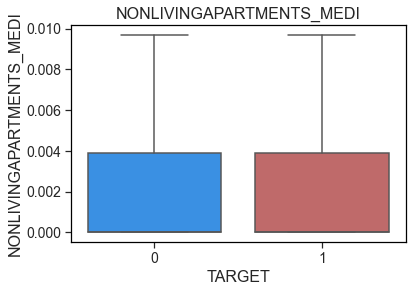

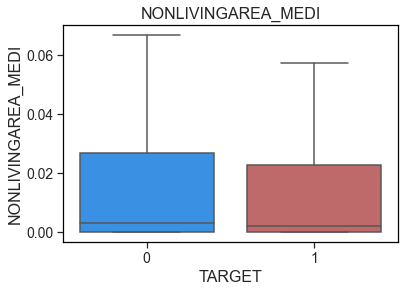

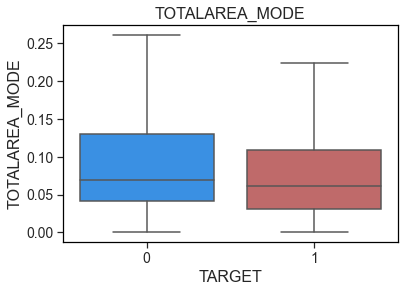

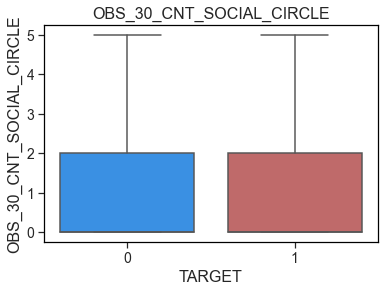

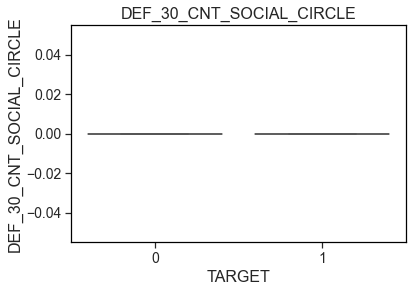

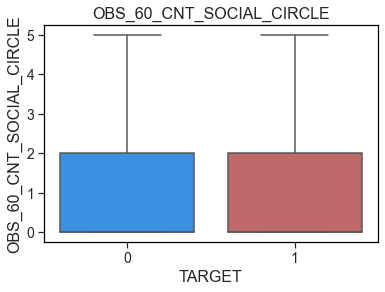

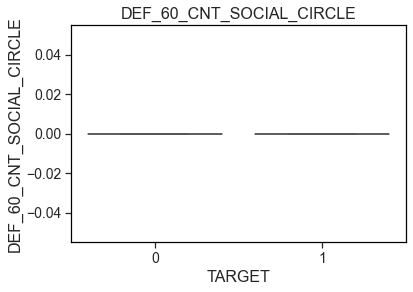

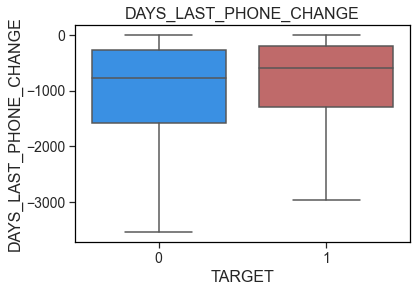

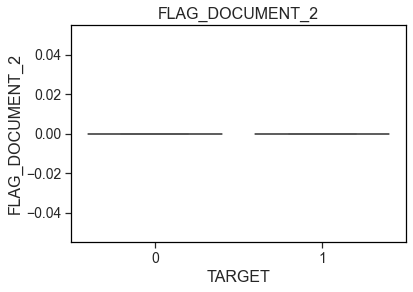

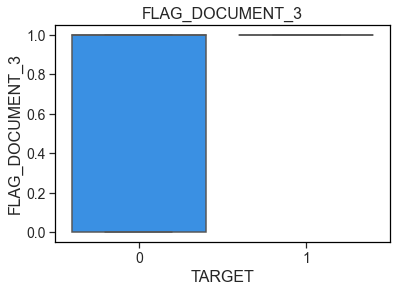

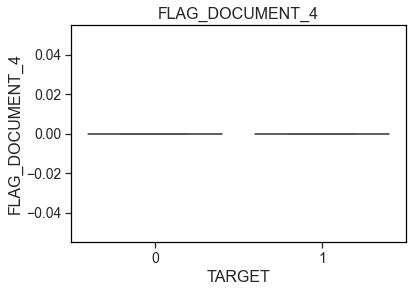

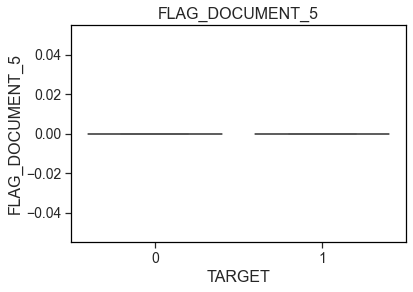

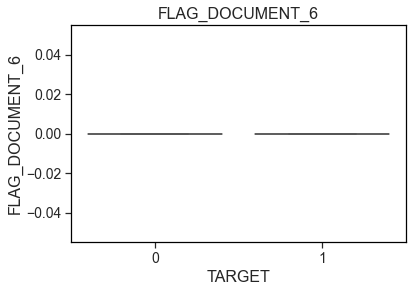

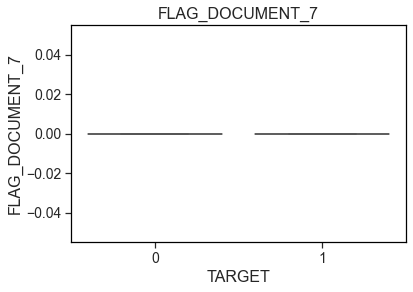

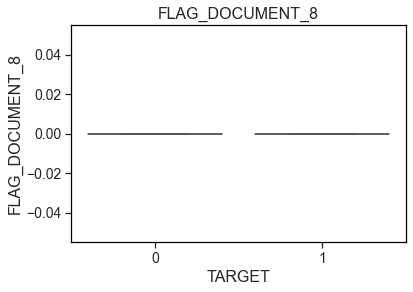

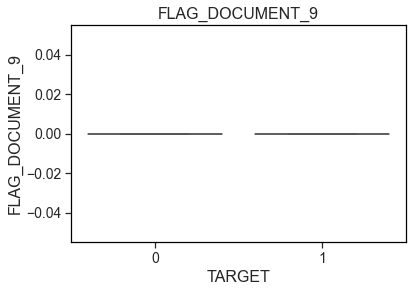

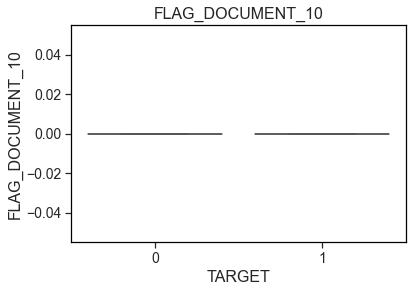

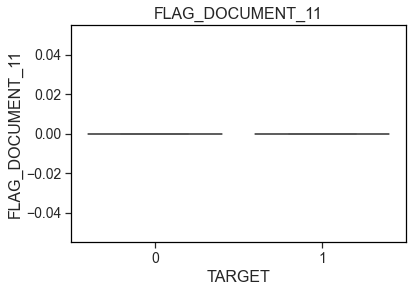

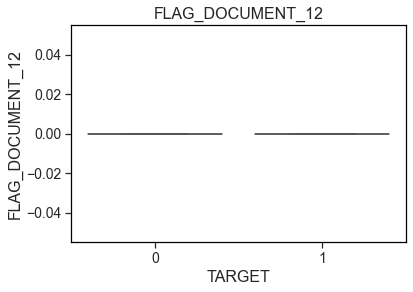

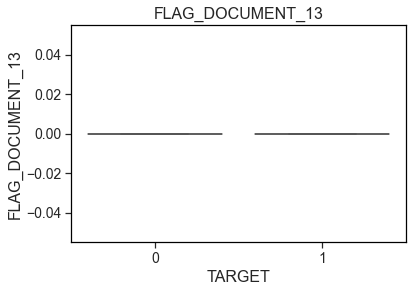

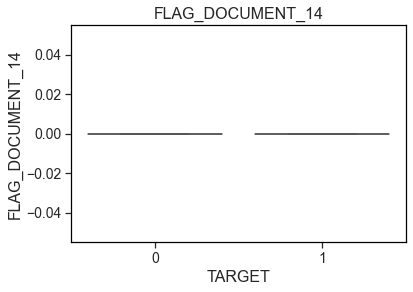

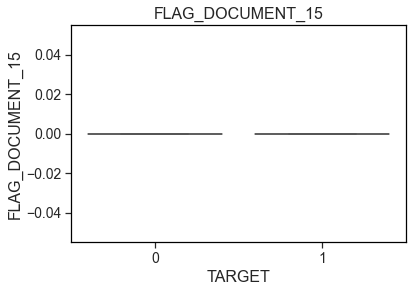

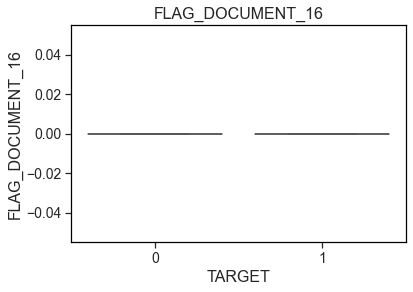

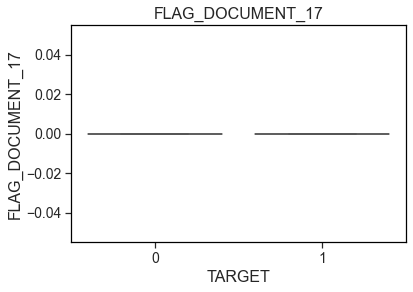

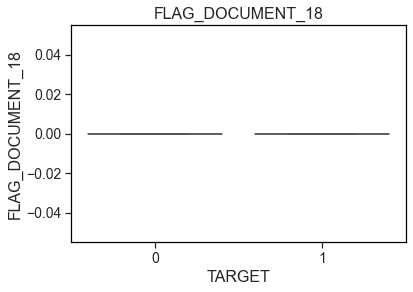

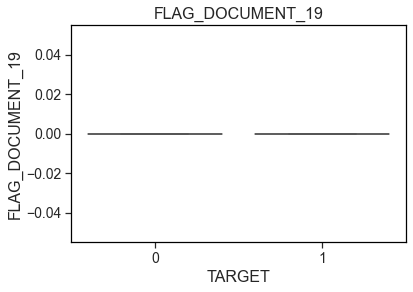

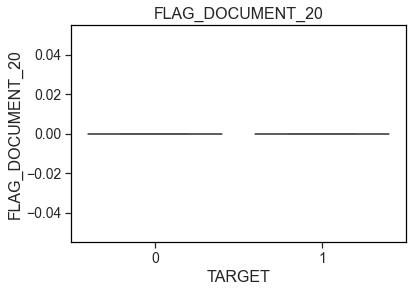

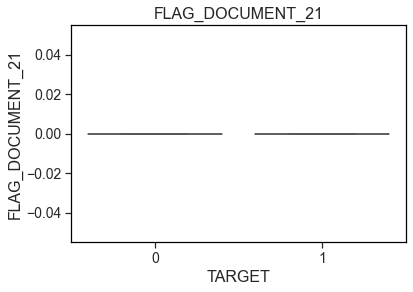

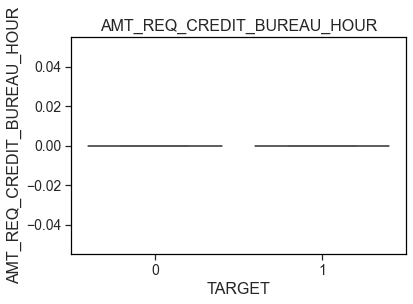

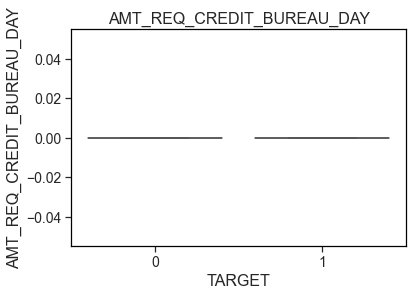

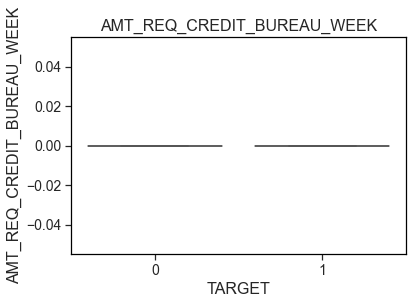

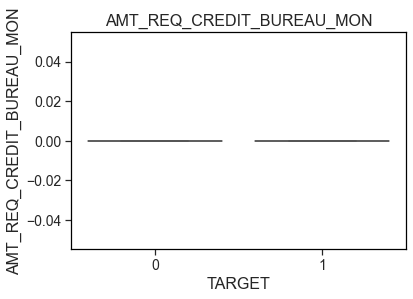

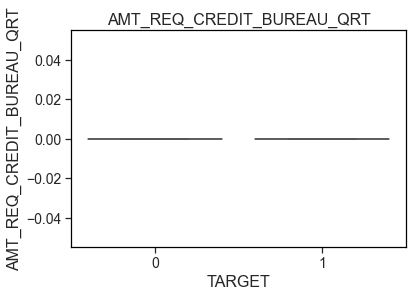

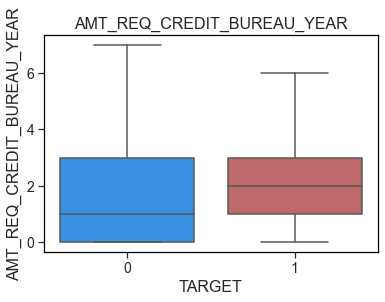

In [185]:
for col in num_col:
    sns.boxplot(data=df,
                  x='TARGET',
                  y=col,
                  showfliers=False,
                  palette=color_bg)
    plt.title(col)
    plt.show()

In [175]:
df_unpay[col].median()

0.0

In [222]:
interest_col = []

for col in num_col:
    if ((df_unpay[col].mean()/df_pay[col].mean() < 0.85)\
        or (df_unpay[col].mean()/df_pay[col].mean() > 1.15))\
    and (df[col].nunique() > 2):
        ratio = df_unpay[col].mean()/df_pay[col].mean()
        std = df_unpay[col].std()/df_pay[col].std()
        interest_col.append(col)
        print(f'{col :_<30} Ratio of means unpay/pay: {ratio:.0%} (std ratio = {std:.0%})')

DAYS_EMPLOYED_________________ Ratio of means unpay/pay: 65% (std ratio = 84%)
EXT_SOURCE_1__________________ Ratio of means unpay/pay: 76% (std ratio = 98%)
EXT_SOURCE_2__________________ Ratio of means unpay/pay: 78% (std ratio = 114%)
EXT_SOURCE_3__________________ Ratio of means unpay/pay: 75% (std ratio = 108%)
ELEVATORS_AVG_________________ Ratio of means unpay/pay: 77% (std ratio = 88%)
ELEVATORS_MODE________________ Ratio of means unpay/pay: 78% (std ratio = 88%)
ELEVATORS_MEDI________________ Ratio of means unpay/pay: 77% (std ratio = 88%)
DEF_30_CNT_SOCIAL_CIRCLE______ Ratio of means unpay/pay: 138% (std ratio = 117%)
DEF_60_CNT_SOCIAL_CIRCLE______ Ratio of means unpay/pay: 143% (std ratio = 120%)
DAYS_LAST_PHONE_CHANGE________ Ratio of means unpay/pay: 83% (std ratio = 91%)
AMT_REQ_CREDIT_BUREAU_DAY_____ Ratio of means unpay/pay: 116% (std ratio = 96%)
AMT_REQ_CREDIT_BUREAU_MON_____ Ratio of means unpay/pay: 84% (std ratio = 80%)


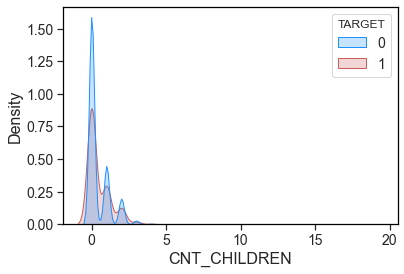

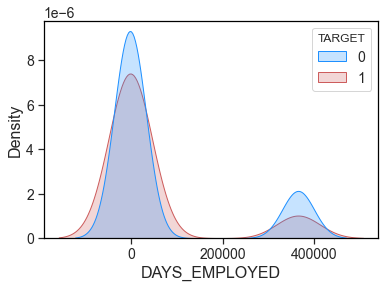

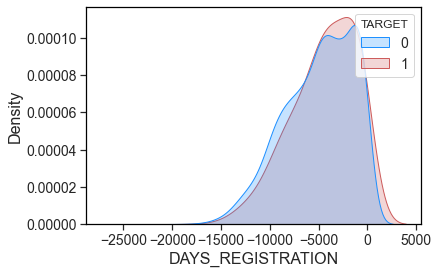

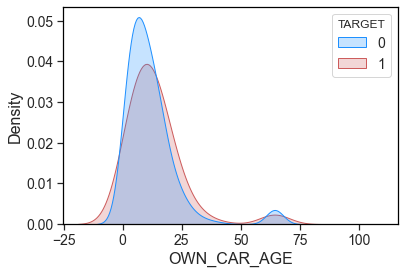

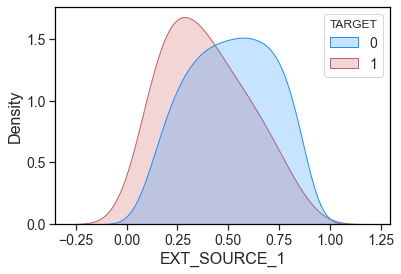

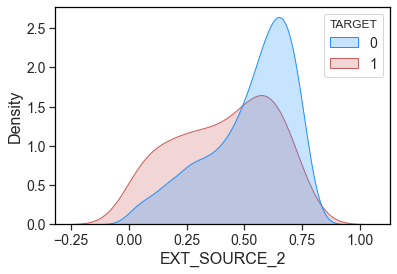

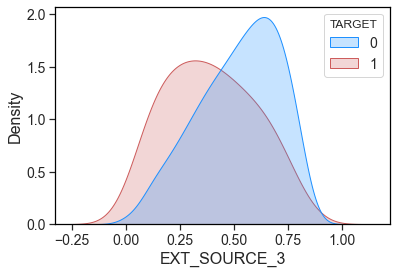

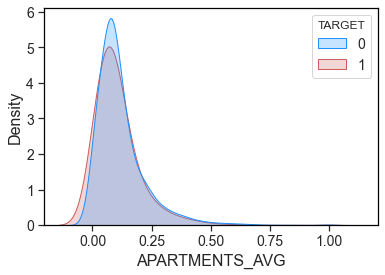

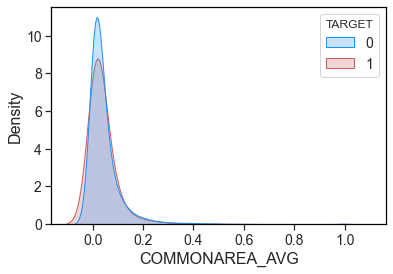

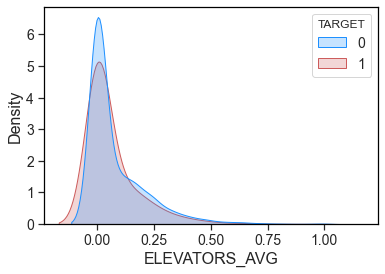

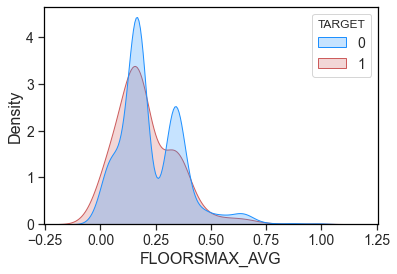

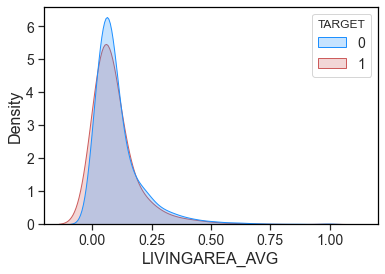

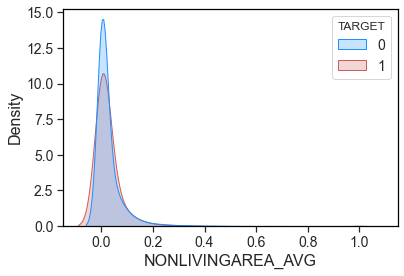

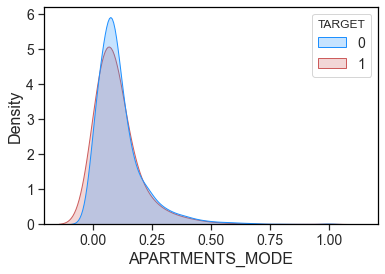

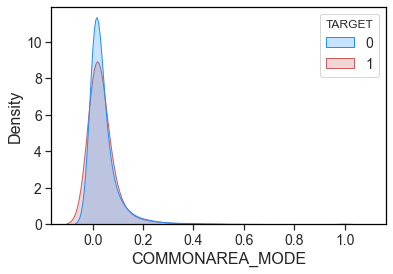

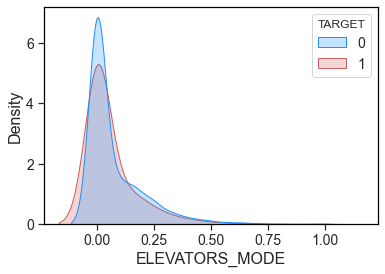

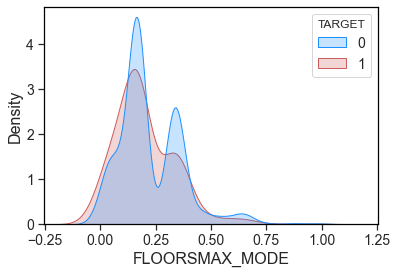

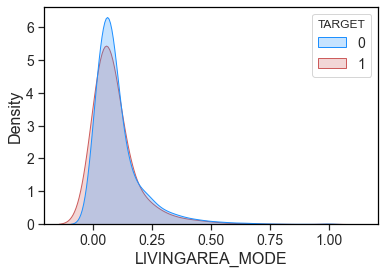

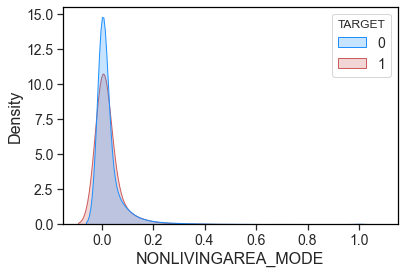

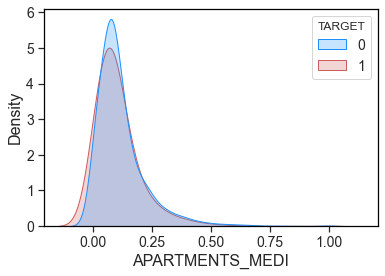

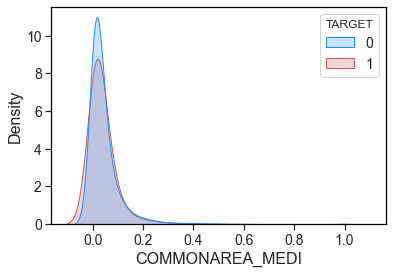

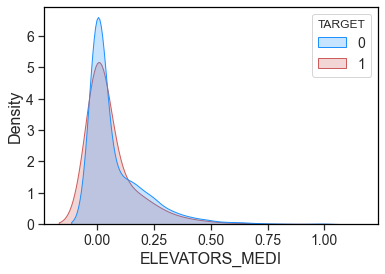

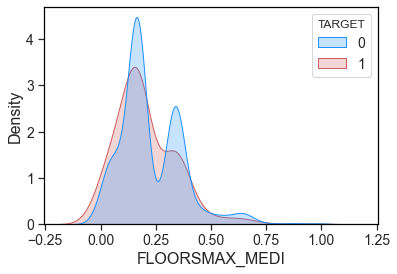

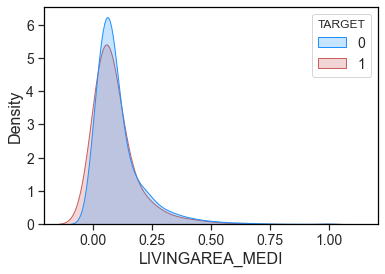

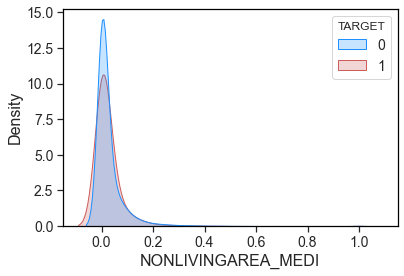

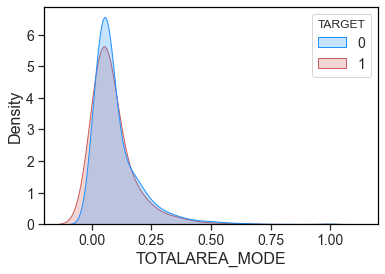

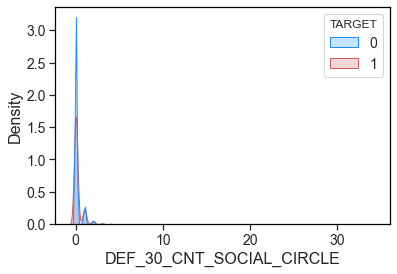

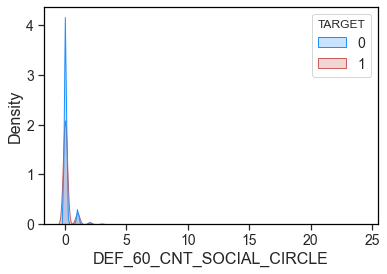

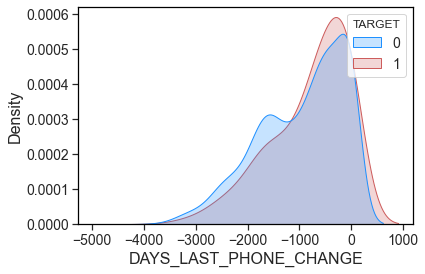

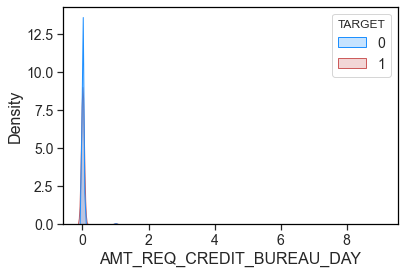

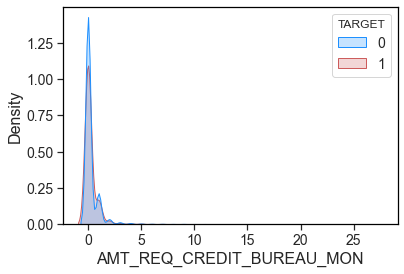

In [221]:
for col in interest_col:
    sns.kdeplot(data=df, x=col, hue='TARGET', bw_adjust=3,
                common_norm=False, fill=True, palette=color_bg)
    plt.show()

## Target/cat var relationships

In [7]:
cat_col = df.select_dtypes(exclude=np.number).columns

In [8]:
df[cat_col].nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

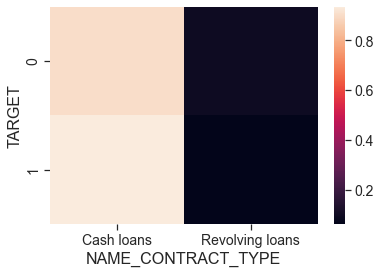

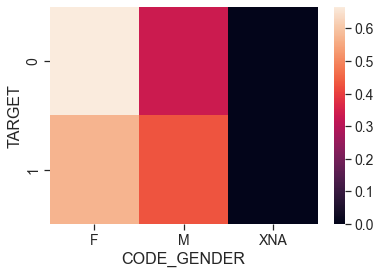

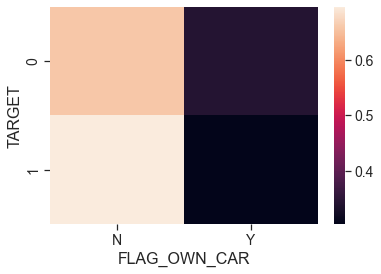

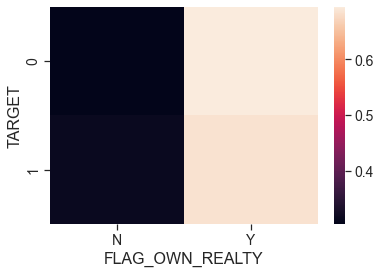

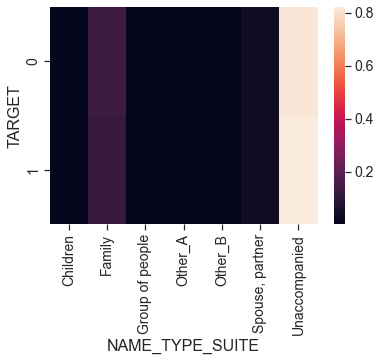

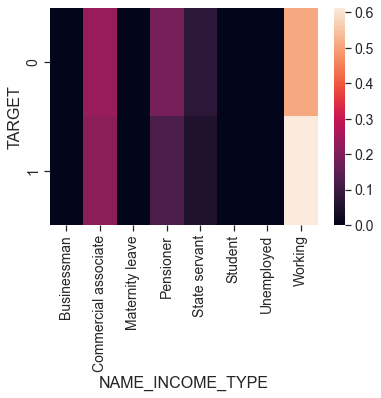

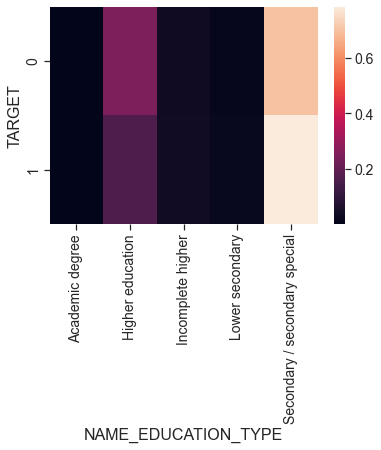

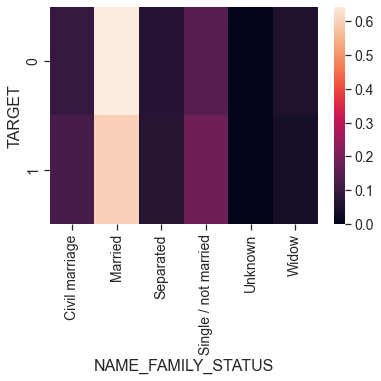

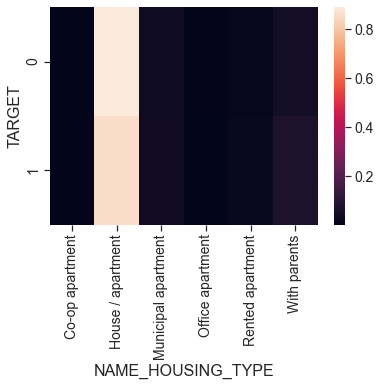

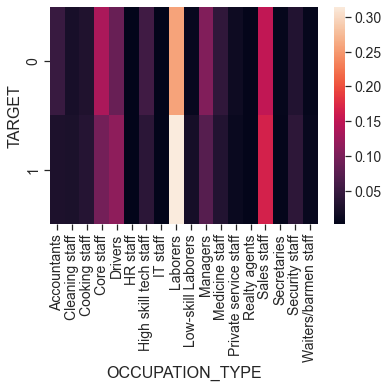

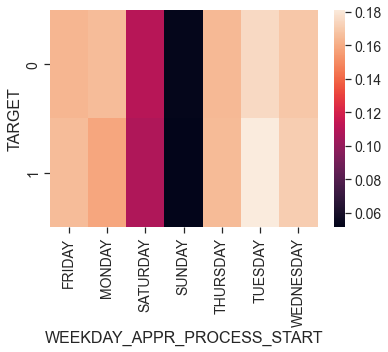

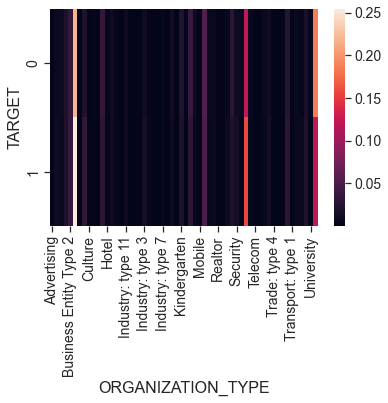

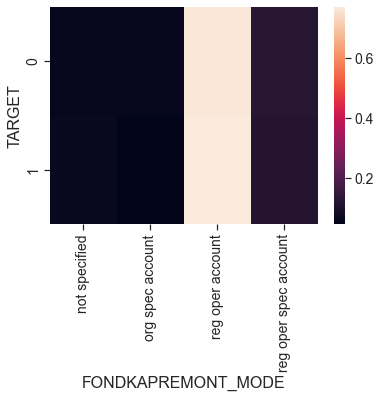

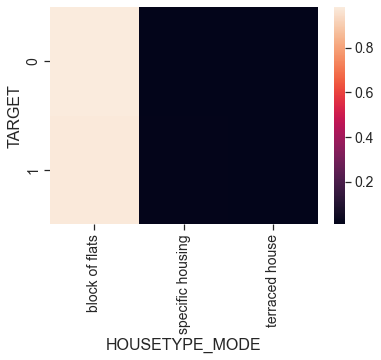

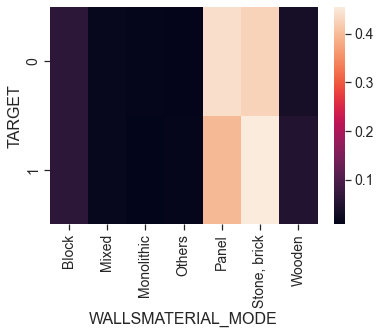

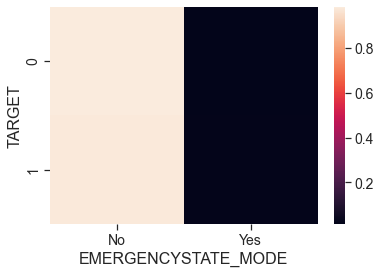

In [130]:
for col in cat_col:
    x_tab = pd.crosstab(df['TARGET'], df[col])
    x_tab = x_tab.apply(lambda x: x/sum(x), axis=1)
    sns.heatmap(x_tab);
    plt.show()

In [143]:
def cramers_corrected_stat(x, y):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher, 
    Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result = -1
    if len(x.value_counts()) == 1:
        print("First variable is constant")
    elif len(y.value_counts()) == 1:
        print("Second variable is constant")
    else:
        conf_matrix = pd.crosstab(x, y)

        if conf_matrix.shape[0] == 2:
            correct = False
        else:
            correct = True

        chi2 = stats.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r, k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return round(result, 2)

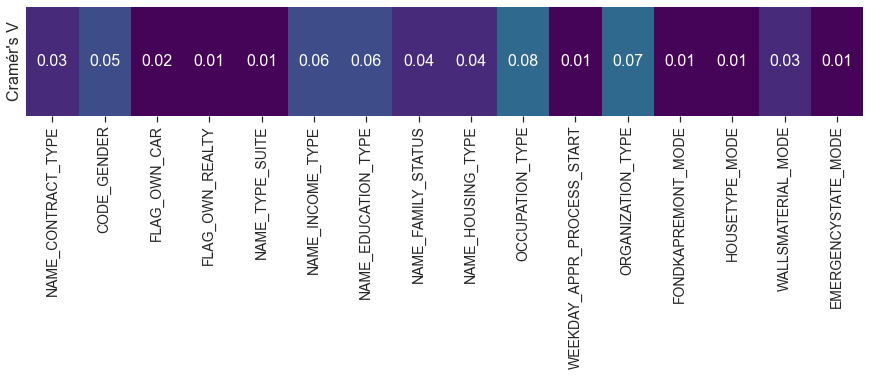

In [155]:
cramers_tab = pd.DataFrame(np.ones((1, len(cat_col)), dtype=float))

cramers_tab.columns = cat_col
cramers_tab.index = ["TARGET"]

for col in cat_col:
    phi = cramers_corrected_stat(df["TARGET"], df[col])
    cramers_tab.loc["TARGET", col] = phi
    
plt.figure(figsize=(15, 2))
sns.heatmap(cramers_tab, annot=True, cmap=my_colors(10)[:4], cbar=False)
plt.ylabel('Cramér\'s V')
plt.yticks([])
plt.show()

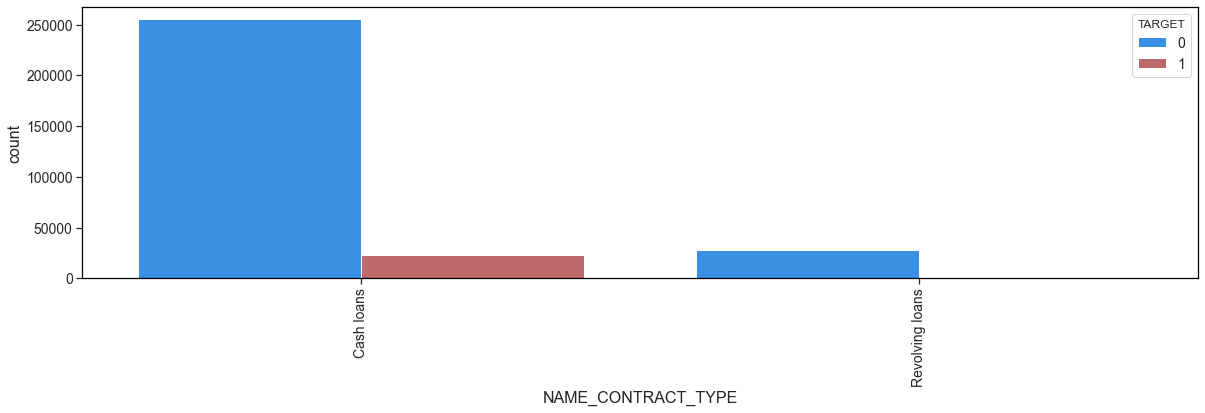

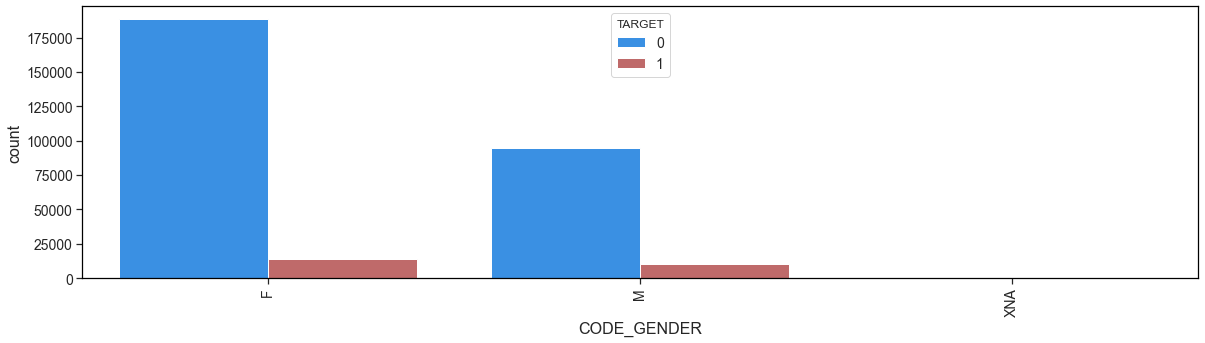

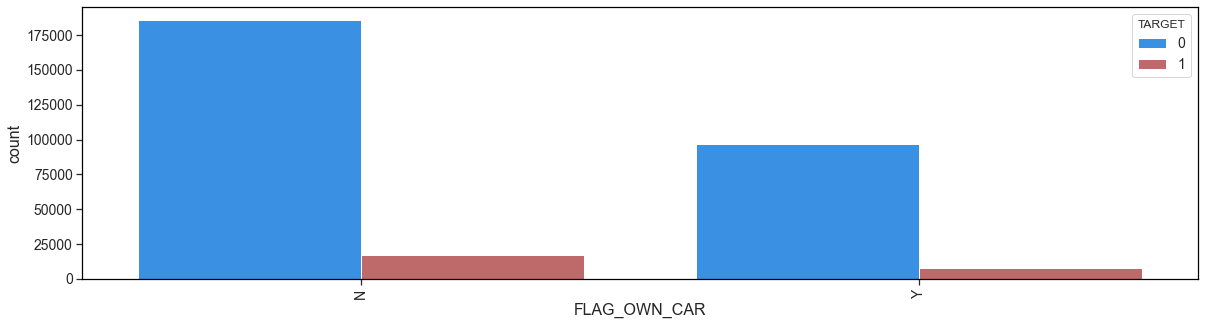

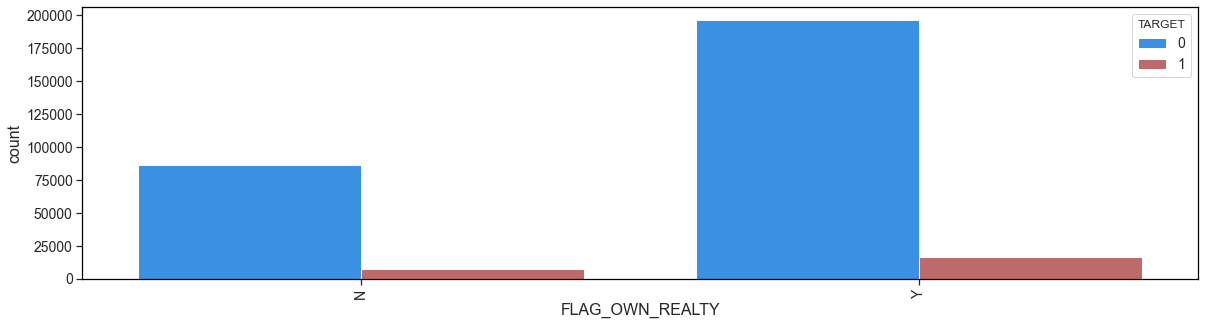

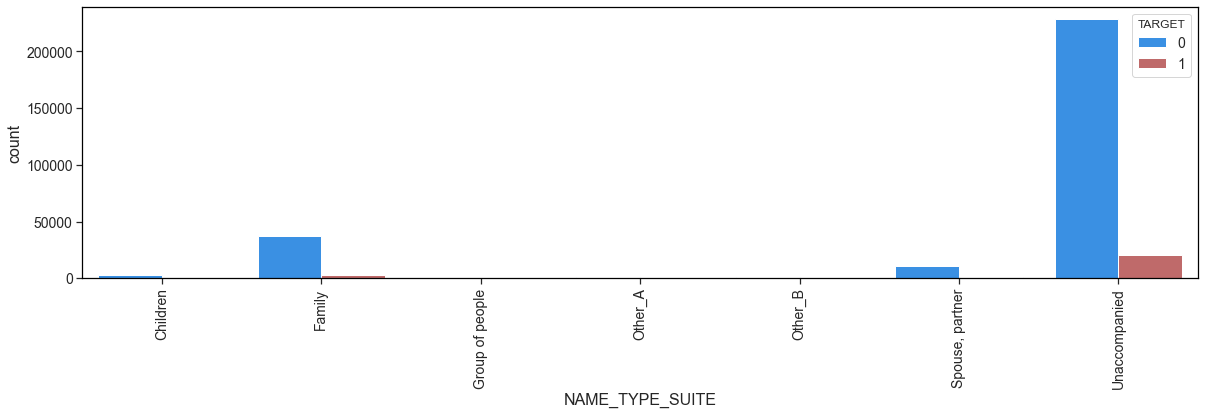

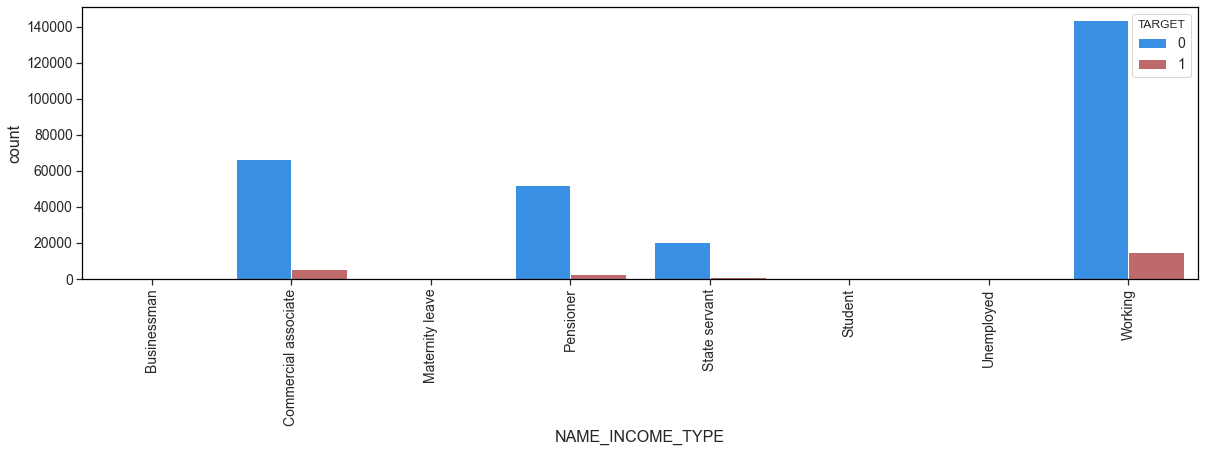

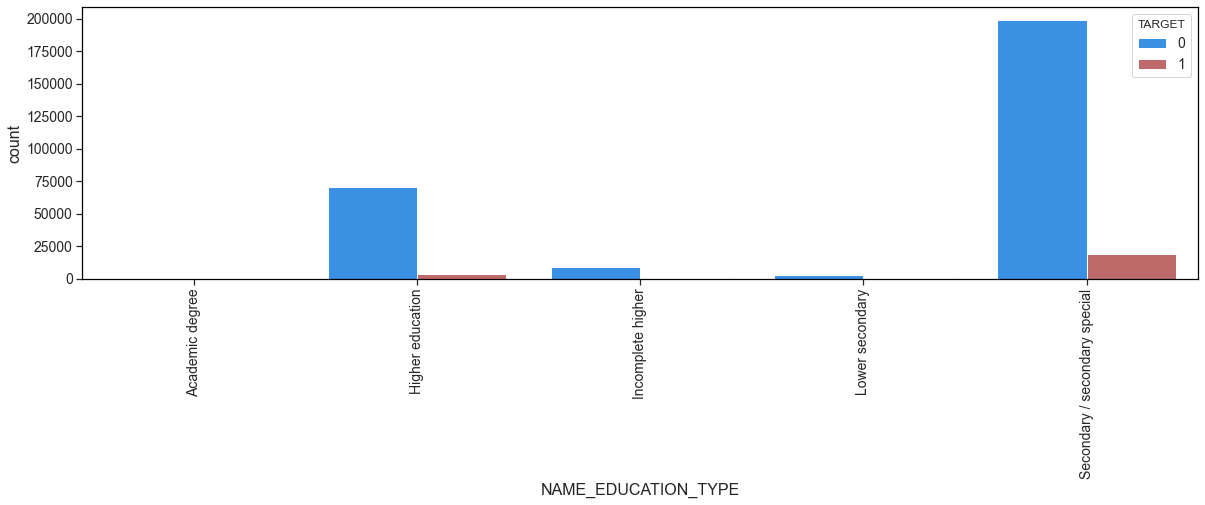

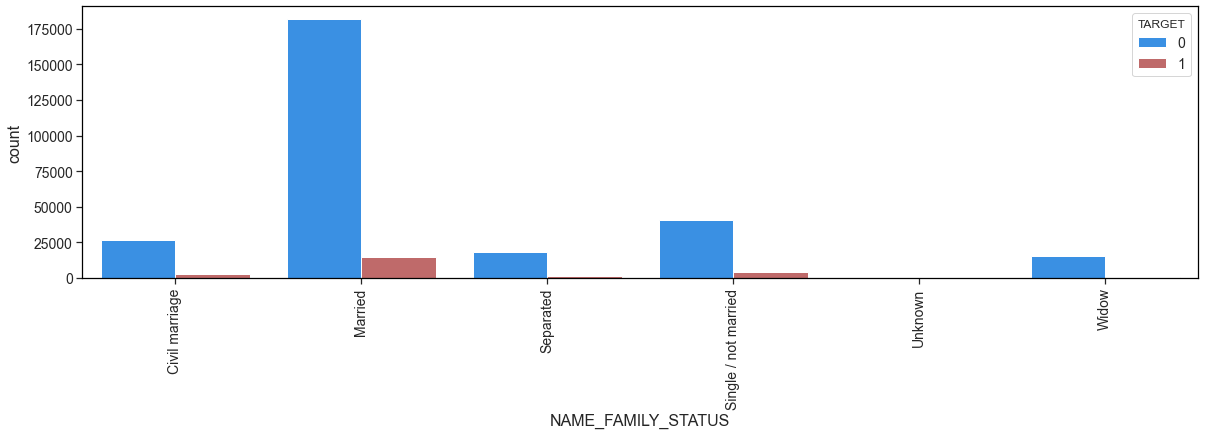

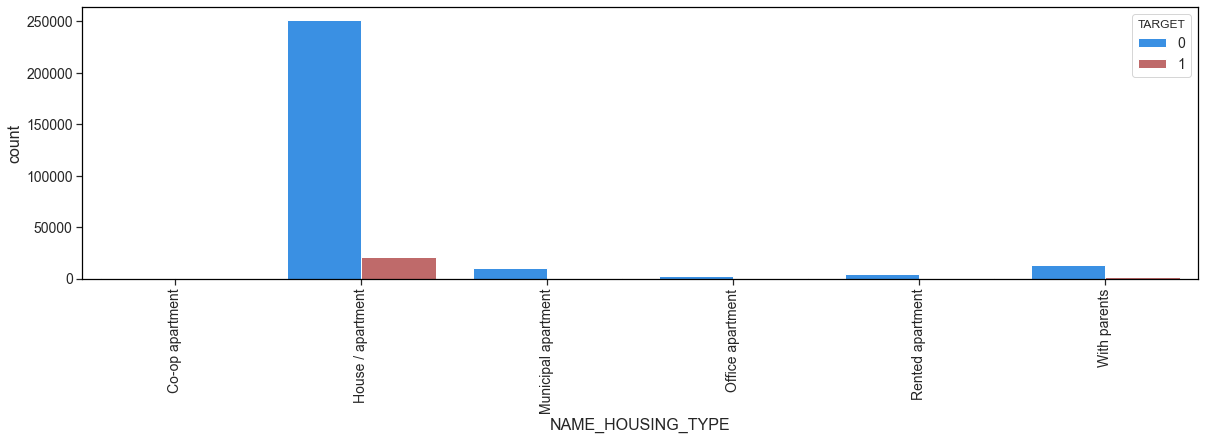

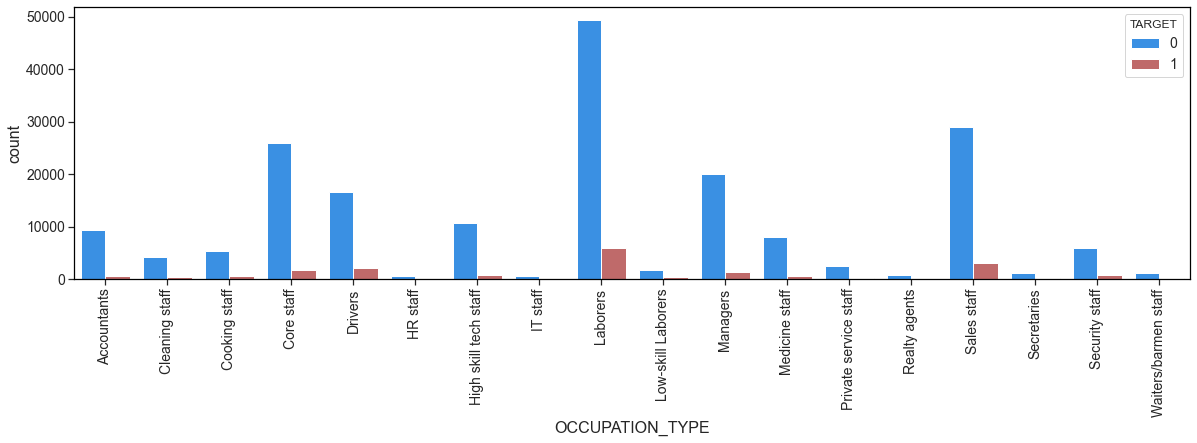

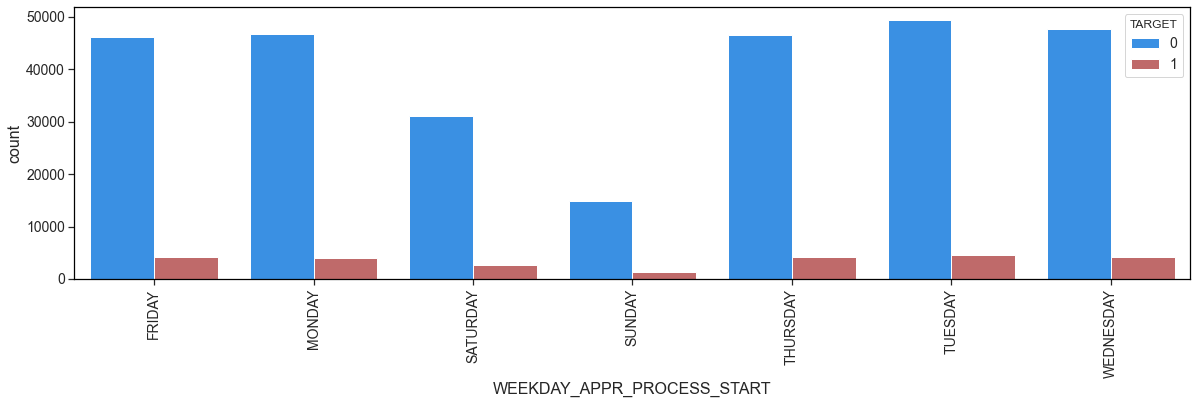

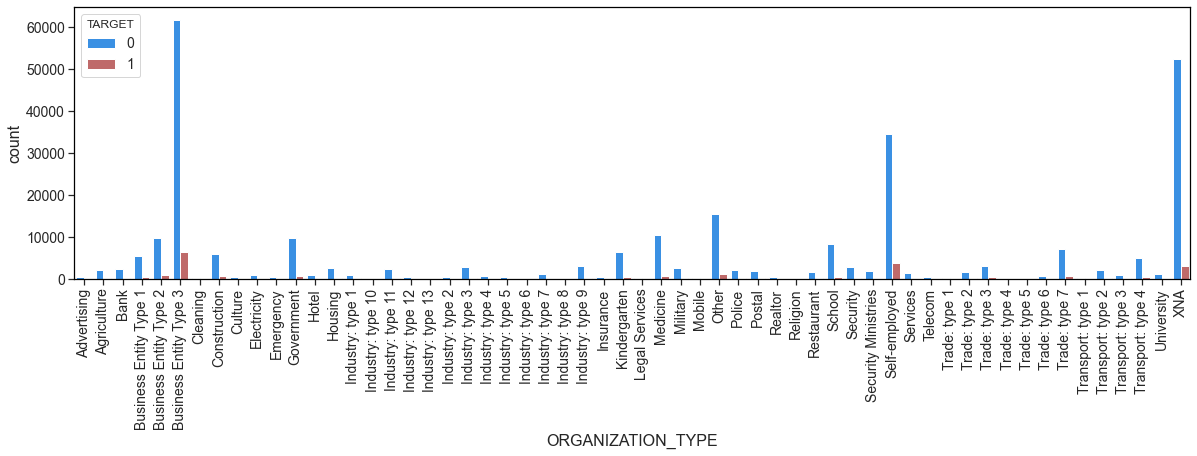

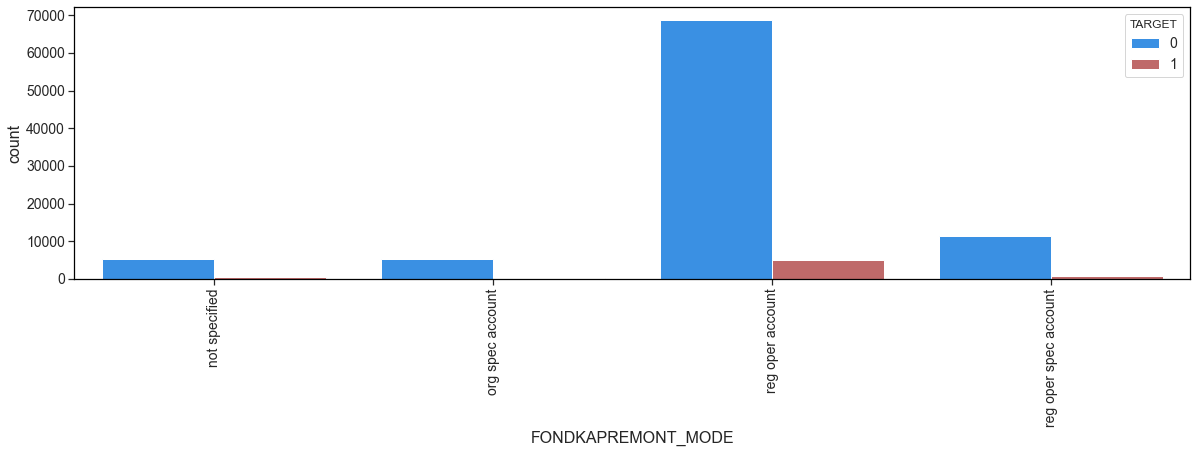

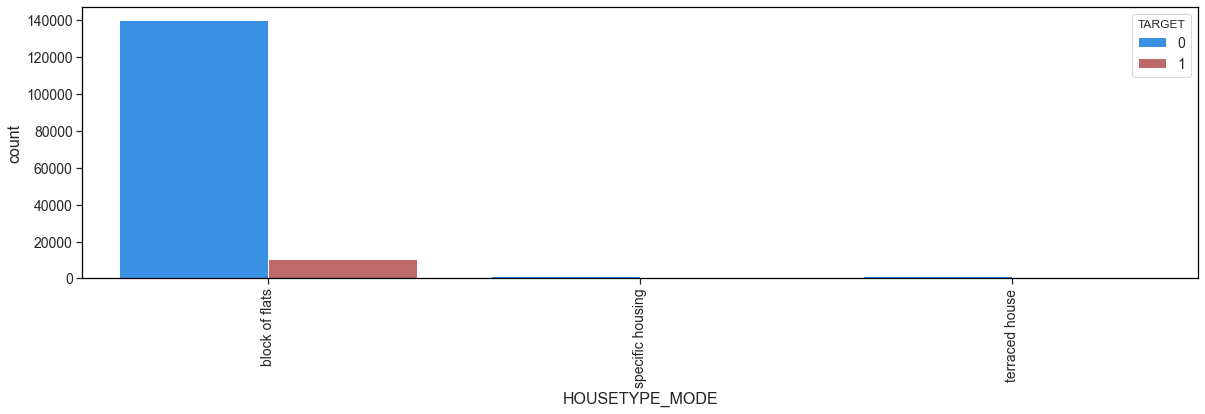

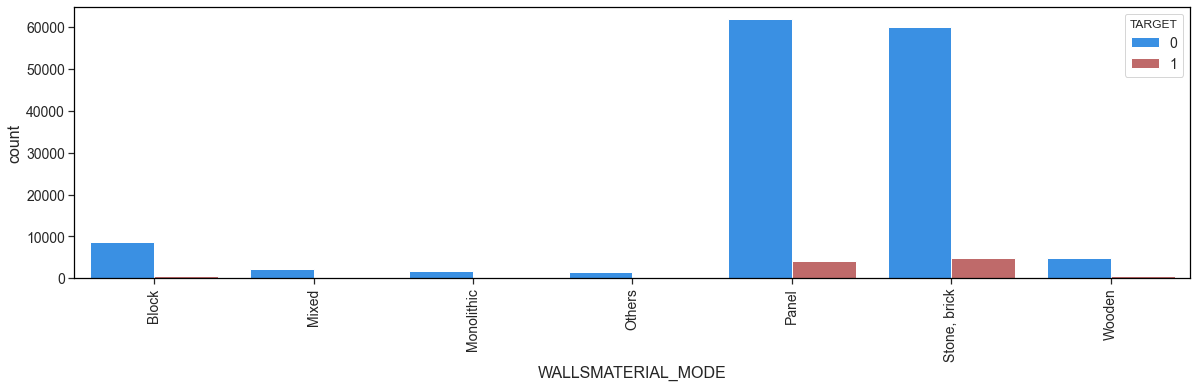

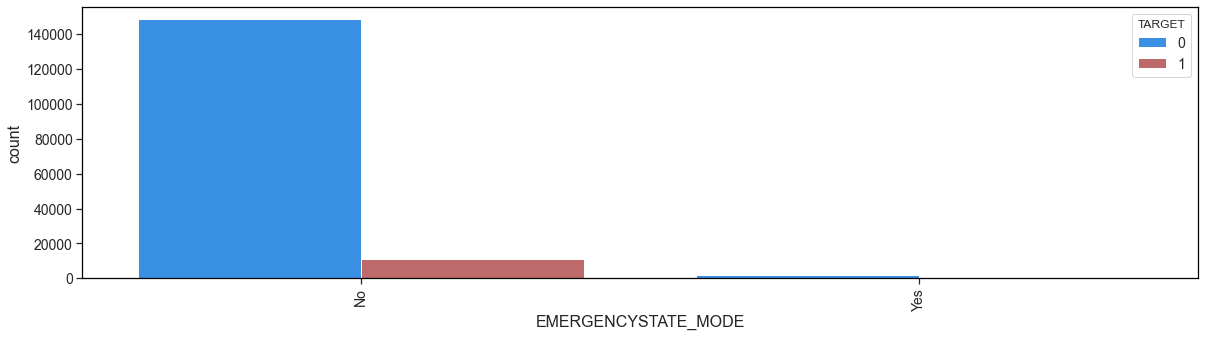

In [261]:
for col in cat_col:
    plt.figure(figsize=(20,5))
    sns.countplot(data=df, x=col, hue="TARGET", palette=color_bg)
    plt.xticks(rotation=90)
    plt.show()

## Bivariate analysis num/num features

In [9]:
df_num = df.select_dtypes(np.number)

for col in df_num.columns:
    if col.endswith("_MEDI") or col.endswith("_MODE"):
        df_num.drop(columns=col, inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


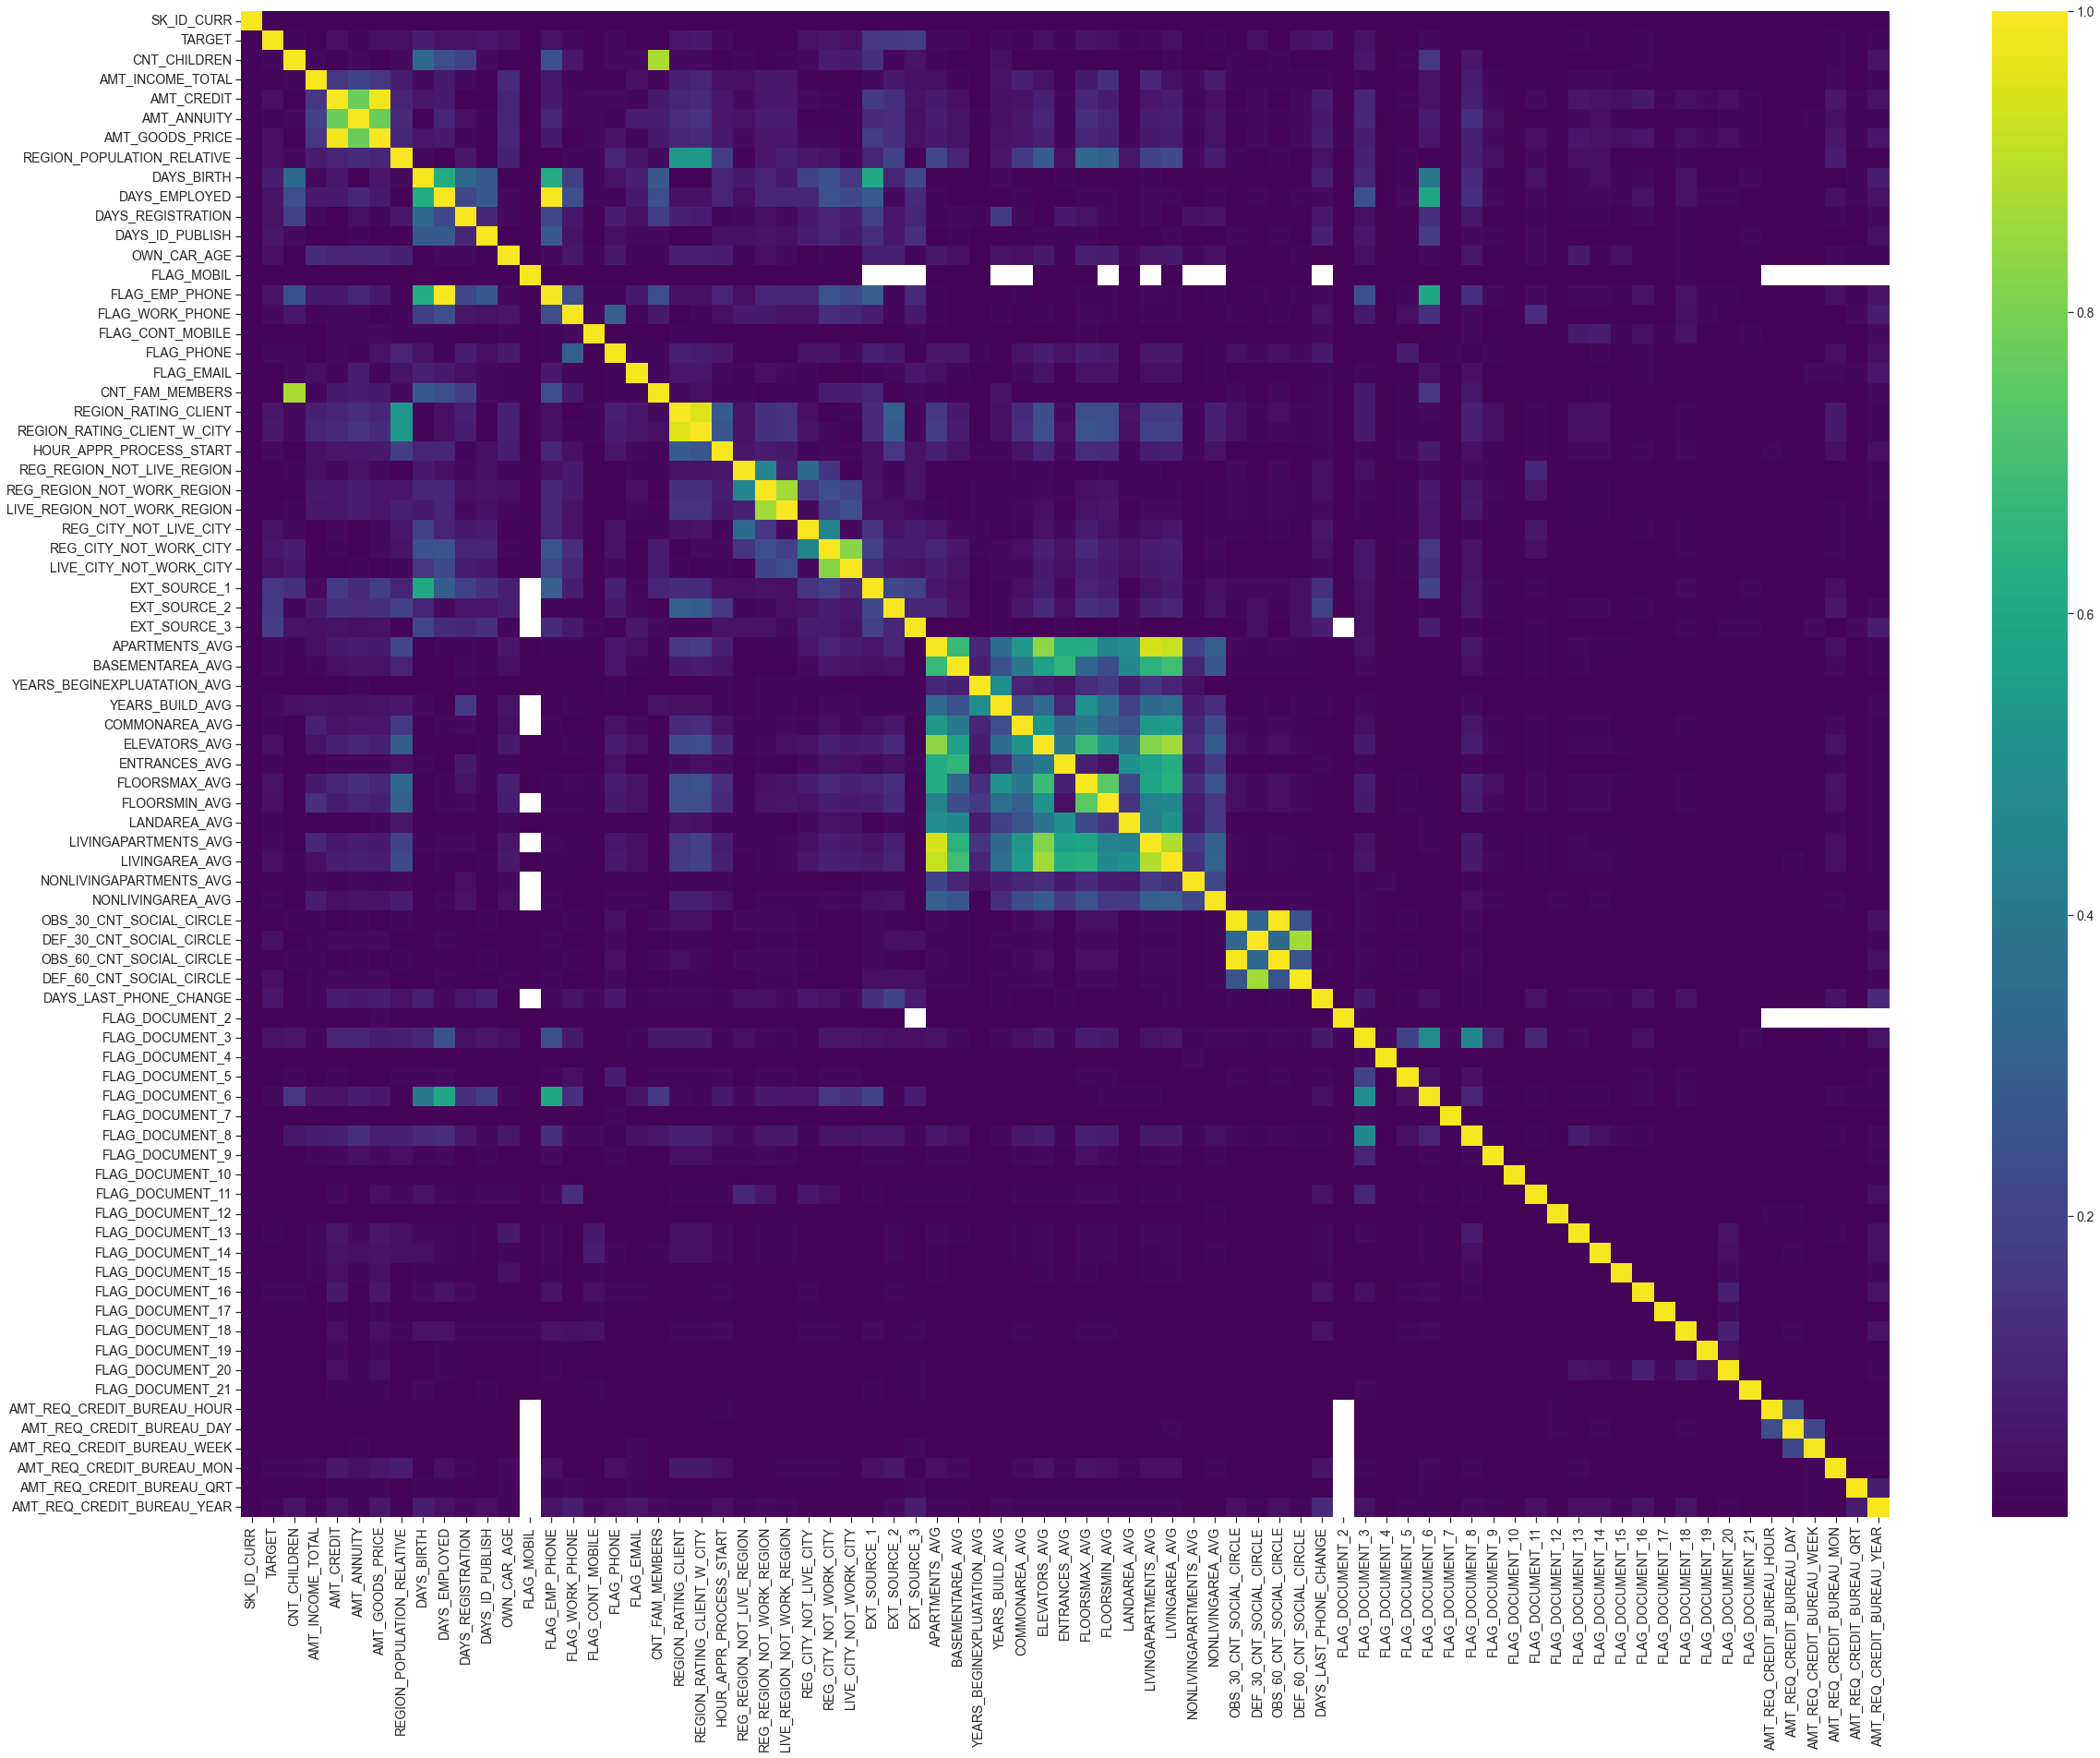

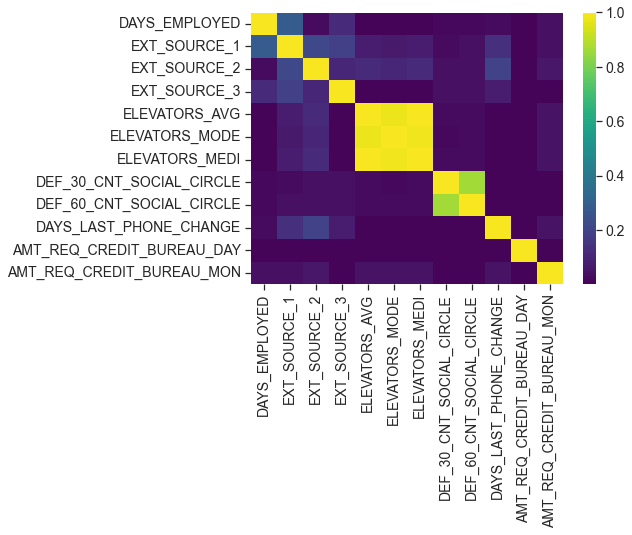

In [254]:
plt.figure(figsize=(40,30))
sns.heatmap(np.abs(df_num.corr()), cmap=my_colors(100));
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(np.abs(df[interest_col].corr()), cmap=my_colors(100));
plt.show()

In [255]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_neg_correlations(df, n=5):
    au_corr = df.corr()[df.corr() < 0].unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]


def get_top_pos_correlations(df, n=5):
    au_corr = df.corr()[df.corr() > 0].unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


top_neg_corr = get_top_neg_correlations(df_num, 20)
top_pos_corr = get_top_pos_correlations(df_num, 150)

Top Negative Correlations


AttributeError: 'Series' object has no attribute 'to_html'

In [ ]:
print("Top Negative Correlations")
display(HTML(pd.DataFrame(top_neg_corr).to_html()))
print("\n")
print("Top Positive Correlations")
display(HTML(pd.DataFrame(top_pos_corr).to_html()))

# First ML approach

Within this approach we'll do a basic and gross cleaning using some inputer, to evaluate the feature importance to have a better lead for performing a second, much finer data cleaning.

In [5]:
df_pay = df[df.TARGET == 0]
df_unpay = df[df.TARGET == 1]
print(f'Len TARGET == 0: {len(df_pay)} and Len TARGET == 1: {len(df_unpay)}')

Len TARGET == 0: 282686 and Len TARGET == 1: 24825


In [6]:
X = df.drop(columns=['SK_ID_CURR','TARGET'])
for col in X.columns:
    if col.endswith("_MEDI") or col.endswith("_MODE"):
        X.drop(columns=col, inplace=True)

y = df['TARGET']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = X.select_dtypes(include=np.number).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
                              )

categorical_features = X.select_dtypes(exclude=np.number).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)
                  ]
)

In [9]:
preprocessor.fit(X_train)
X_train_sc = preprocessor.transform(X_train)
X_test_sc = preprocessor.transform(X_test)

In [70]:
from sklearn.metrics import SCORERS

SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
###############################################
#  Tested_model but too long or not efficient
###############################################
# gbc = GradientBoostingClassifier(
#     n_estimators=100, max_features=None, random_state=13)
# gbc_grid = {'n_estimators': [300],
#             'learning_rate': [0.6],
#             'subsample': [1]}
# xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, 
#                     objective='binary:logistic', silent=True, nthread=1, )
# xgb_params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }
###############################################

In [1]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

n = 25
weight = 10 len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      scale_pos_weight=weight,
                      )

lgbm_param = {'num_leaves': np.linspace(10, 80, 7, dtype='int'),
              'min_child_samples': stats.randint(100, 500),
              'min_child_weight': [1e-5, 1e-2, 1, 1e2, 1e4],
              'subsample': stats.uniform(loc=0.2, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0.1, 1,  10, 100],
              'reg_lambda': [0.1, 1, 10,  50, 100]}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=3,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train_sc, y_train)

print(round(grid.best_score_, 3))
print(grid.best_params_)
optima = pd.DataFrame(grid.cv_results_).T
optima

NameError: name 'df_pay' is not defined

In [12]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

n = 25
weight = len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      scale_pos_weight=weight,
                      )

scoring = ['roc_auc','precision','recall','f1']

x_val = cross_validate(lgbm,
                        X_train_sc,
                        y_train,
                        cv=3,
                        scoring=scoring)




In [22]:
pd.DataFrame(x_val).mean(axis=0)

fit_time          7.282232
score_time        1.381998
test_roc_auc      0.753246
test_precision    0.173183
test_recall       0.640655
test_f1           0.272656
dtype: float64

In [23]:
time, unk, auc, precision, recall, f1 = pd.DataFrame(x_val).mean(axis=0)

7.282232046127319

TN = 38290, FP = 18277, FN = 1445, TP = 3491
Testset: threshold = 47%, G-Mean= 69%, AUC = 69%, recall= 71%, f1 = 26%


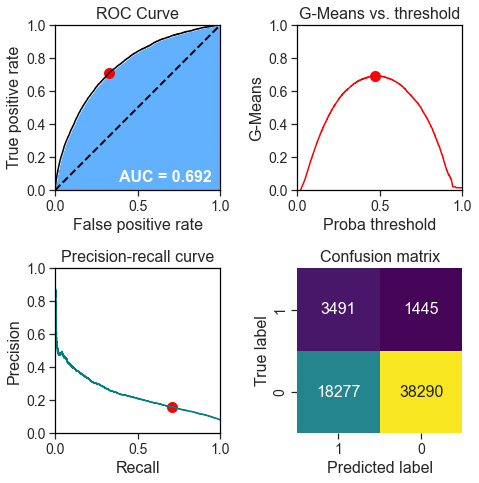

In [197]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics

model = grid.best_estimator_
model.fit(X_train_sc, y_train)

y_prob = model.predict_proba(X_test_sc)
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

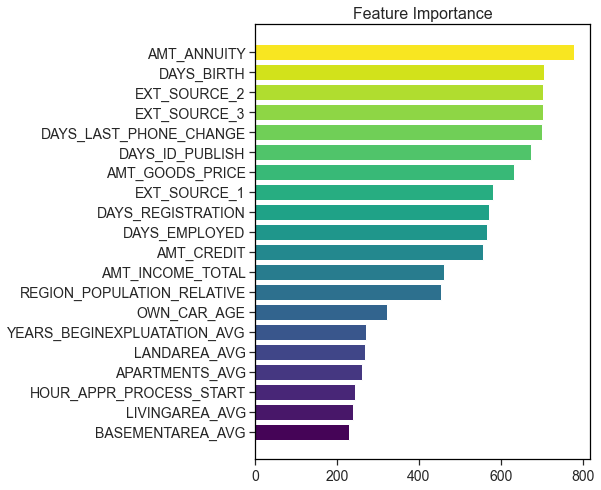

In [52]:
from sklearn.inspection import permutation_importance

# Recover features columns (especially after OneHotEncoder)
onehot_columns = list(preprocessor.named_transformers_[
                      'cat'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
features_list = np.concatenate((numeric_features_list, onehot_columns))

# Recover important features from previous fit and then permute importance
n_feat = 20  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6, 8))
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center', color=my_colors(20))
plt.yticks(pos[-1*n_feat:], features_list[sorted_idx][-1*n_feat:])
plt.title('Feature Importance')
plt.show()

# LightGBM with prior class balancing

In [149]:
df_pay = df[df.TARGET == 0]
df_unpay = df[df.TARGET == 1]
print(f'Len TARGET == 0: {len(df_pay)} and Len TARGET == 1: {len(df_unpay)}')

Len TARGET == 0: 282686 and Len TARGET == 1: 24825


In [150]:
df_samp = df.copy()
df_samp = df_samp[df_samp['TARGET'] == 0].sample(len(df_unpay))
df_samp_concat = pd.concat([df_unpay, df_samp], axis=0)
df_samp_concat.shape

(49650, 122)

In [151]:
X = df_samp_concat.drop(columns=['SK_ID_CURR','TARGET'])
for col in X.columns:
    if col.endswith("_MEDI") or col.endswith("_MODE"):
        X.drop(columns=col, inplace=True)

y = df_samp_concat['TARGET']

In [152]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [153]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

numeric_features = X.select_dtypes(include=np.number).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
                              )

categorical_features = X.select_dtypes(exclude=np.number).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)
                  ]
)

In [154]:
preprocessor.fit(X_train)
X_train_sc = preprocessor.transform(X_train)
X_test_sc = preprocessor.transform(X_test)

In [155]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

n = 10
weight = len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      #scale_pos_weight=weight,
                      )

lgbm_param = {'num_leaves': np.linspace(10,80,7, dtype='int'),
              'min_child_samples': stats.randint(100, 500),
              'min_child_weight': [1e-5, 1e-2, 1, 1e2, 1e4],
              'subsample': stats.uniform(loc=0.2, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0.1, 1,  10, 100],
              'reg_lambda': [0.1, 1, 10,  50, 100]}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=3,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train_sc, y_train)

print(round(grid.best_score_, 3))
print(grid.best_params_)
optima = pd.DataFrame(grid.cv_results_).T
optima

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.752
{'colsample_bytree': 0.7571223645945877, 'min_child_samples': 343, 'min_child_weight': 100.0, 'num_leaves': 80, 'reg_alpha': 10, 'reg_lambda': 50, 'subsample': 0.7345523536206009}


0  \
mean_fit_time                                                      9.57792   
std_fit_time                                                      0.215727   
mean_score_time                                                   1.388278   
std_score_time                                                    0.014298   
param_colsample_bytree                                            0.866621   
param_min_child_samples                                                174   
param_min_child_weight                                             0.00001   
param_num_leaves                                                        80   
param_reg_alpha                                                         10   
param_reg_lambda                                                       100   
param_subsample                                                   0.343323   
params                   {'colsample_bytree': 0.8666214463442921, 'min_...   
split0_test_score                                                 0.749944   
split1_test_score                                                 0.747442   
split2_test_score                                                 0.756309   
mean_test_score                                                   0.751232   
std_test_score                                                    0.003732   
rank_test_score                                                          3   

                                                                         1  \
mean_fit_time                                                     7.746743   
std_fit_time                                                        0.1459   
mean_score_time                                                   1.559727   
std_score_time                                                    0.087279   
param_colsample_bytree                                             0.85515   
param_min_child_samples                                                344   
param_min_child_weight                                                   1   
param_num_leaves                                                        80   
param_reg_alpha                                                         10   
param_reg_lambda                                                        10   
param_subsample                                                   0.228029   
params                   {'colsample_bytree': 0.8551504021292146, 'min_...   
split0_test_score                                                 0.749143   
split1_test_score                                                 0.747404   
split2_test_score                                                 0.755253   
mean_test_score                                                     0.7506   
std_test_score                                                    0.003366   
rank_test_score                                                          4   

                                                                         2  \
mean_fit_time                                                     4.544311   
std_fit_time                                                      0.127255   
mean_score_time                                                   0.482686   
std_score_time                                                    0.025199   
param_colsample_bytree                                             0.57907   
param_min_child_samples                                                260   
param_min_child_weight                                               100.0   
param_num_leaves                                                        68   
param_reg_alpha                                                        100   
param_reg_lambda                                                        50   
param_subsample                                                   0.597604   
params                   {'colsample_bytree': 0.5790696825335077, 'min_...   
split0_test_score                                                 0.745469   
split1_test_sco

In [61]:
gc.collect()

0

TN = 3378, FP = 1589, FN = 1498, TP = 3465
Testset: threshold = 48%, G-Mean= 69%, AUC = 69%, recall= 70%, f1 = 69%


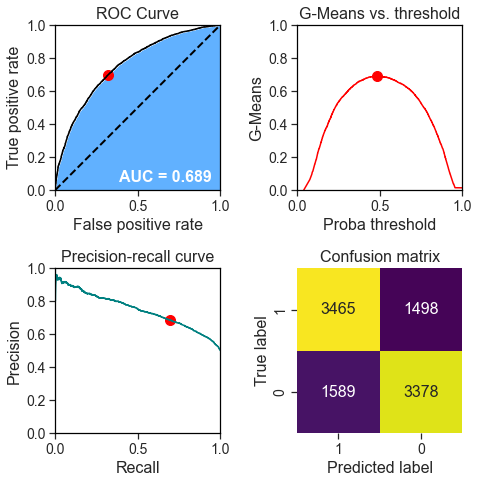

In [156]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics

model = grid.best_estimator_
model.fit(X_train_sc, y_train)

y_prob = model.predict_proba(X_test_sc)
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

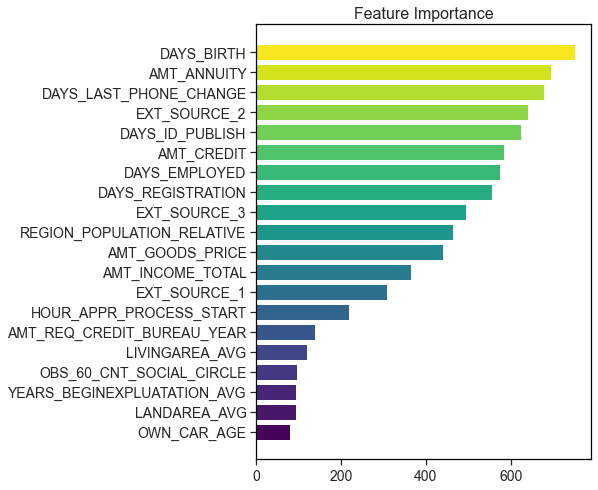

In [158]:
from sklearn.inspection import permutation_importance

# Recover features columns (especially after OneHotEncoder)
onehot_columns = list(preprocessor.named_transformers_[
                      'cat'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
features_list = np.concatenate((numeric_features_list, onehot_columns))

# Recover important features from previous fit and then permute importance
n_feat = 20  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6, 8))
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center', color=my_colors(20))
plt.yticks(pos[-1*n_feat:], features_list[sorted_idx][-1*n_feat:])
plt.title('Feature Importance')
plt.show()


# t-SVD+LGBM

In [159]:
df_pay = df[df.TARGET == 0]
df_unpay = df[df.TARGET == 1]
print(f'Len TARGET == 0: {len(df_pay)} and Len TARGET == 1: {len(df_unpay)}')

Len TARGET == 0: 282686 and Len TARGET == 1: 24825


In [160]:
df_samp = df.copy()
df_samp = df_samp[df_samp['TARGET'] == 0].sample(len(df_unpay))
df_samp_concat = pd.concat([df_unpay, df_samp], axis=0)
df_samp_concat.shape

(49650, 122)

In [161]:
X = df_samp_concat.drop(columns=['SK_ID_CURR','TARGET'])
for col in X.columns:
    if col.endswith("_MEDI") or col.endswith("_MODE"):
        X.drop(columns=col, inplace=True)

y = df_samp_concat['TARGET']

In [162]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [163]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

numeric_features = X.select_dtypes(include=np.number).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
                              )

categorical_features = X.select_dtypes(exclude=np.number).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)
                  ]
)

In [164]:
preprocessor.fit(X_train)
X_train_sc = preprocessor.transform(X_train)
X_test_sc = preprocessor.transform(X_test)

In [165]:
pd.DataFrame(X_train_sc)

0         1         2         3         4         5         6    \
0      0.763917  0.049660  1.742325  0.691636  1.643378 -0.773716  0.225217   
1     -0.588076 -0.220876 -1.390597 -1.534829 -1.348288 -0.996675 -1.259246   
2     -0.588076 -0.017974  0.847505  1.407157  1.118524 -0.376417 -0.946825   
3      0.763917 -0.085608 -0.787961 -0.562169 -0.849677 -0.434377  0.532555   
4     -0.588076  0.094750  0.389981 -0.396113  0.265637  4.009799 -0.567390   
...         ...       ...       ...       ...       ...       ...       ...   
39715 -0.588076  0.132324 -0.095518 -0.094253 -0.193610 -0.079342 -0.376055   
39716 -0.588076  0.132324  4.167788  2.368966  4.097068 -1.349949 -0.872186   
39717 -0.588076 -0.055548  0.847505  1.543619  1.118524  1.198615  0.940413   
39718  0.763917 -0.017974 -0.970636 -1.146489 -0.980890 -0.098560  0.372416   
39719  0.763917  0.320196 -0.826217 -0.973856 -0.718463  0.812954 -0.016725   

            7         8         9    ...  190  191  192  193  194  195  196  \
0     -0.426110  0.963776 -1.267069  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      2.342859  0.774374  0.495138  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     -0.469619 -0.606141 -0.156655  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     -0.429586 -0.536606  0.363071  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     -0.417357 -1.896755  0.900537  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
39715 -0.412954 -0.094085  1.610808  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39716 -0.435368 -1.783579  0.037831  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39717 -0.445923  0.669344  0.255315  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39718 -0.421164  1.157834 -1.592308  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39719 -0.416897  0.456084 -0.924746  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       197  198  199  
0      0.0  0.0  0.0  
1      0.0  0.0  1.0  
2      0.0  0.0  0.0  
3      0.0  0.0  0.0  
4      0.0  0.0  0.0  
...    ...  ...  ...  
39715  0.0  1.0  0.0  
39716  0.0  0.0  0.0  
39717  0.0  0.0  0.0  
39718  0.0  0.0  0.0  
39719  0.0  0.0  0.0  

[39720 rows x 200 columns]

In [166]:
X_train_pca

array([[-1.80257412e+00,  2.36383694e+00, -4.29123917e-01, ...,
         1.20543582e+00, -5.66124969e-01, -3.18946268e-01],
       [ 1.00159762e+00,  2.28910911e+00,  2.45049809e+00, ...,
        -1.05194106e+00, -3.10984579e-01,  3.52721562e-01],
       [-3.47434351e+00,  2.02129715e+00, -3.72621124e+00, ...,
        -5.44441487e-01,  1.07632979e+00, -7.15821487e-02],
       ...,
       [-1.49597553e+00,  1.92864112e+00,  1.48403195e+00, ...,
        -1.37418653e+00,  2.71934557e-01, -4.29936689e-01],
       [-8.61710964e-01,  2.44265150e+00,  2.66719345e+00, ...,
         2.75834591e-03,  1.52087368e-02, -7.18020247e-01],
       [-1.40565413e+00,  2.35173550e+00,  1.77105245e+00, ...,
        -7.50828066e-02, -3.87260359e-02,  1.43990878e-01]])

In [172]:
np.where(variance > 0.95)

(array([ 67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
        197, 198], dtype=int64),)

67


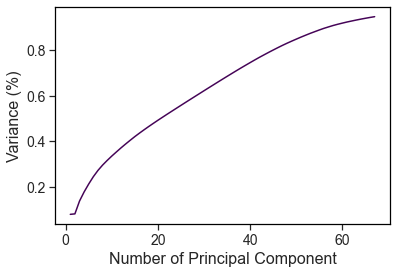

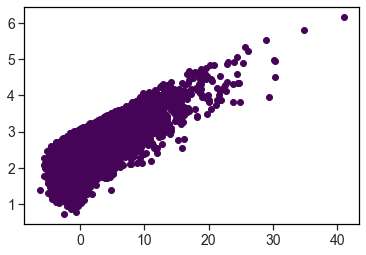

In [173]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(67, n_iter=10)

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
print(len(pca.explained_variance_ratio_))
variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.linspace(1,len(variance),len(variance)), variance)
plt.xlabel('Number of Principal Component')
plt.ylabel('Variance (%)')
plt.show()

plt.scatter(X_train_pca[:,0], X_train_pca[:,1])
plt.show()


In [176]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

n = 10
weight = len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      #scale_pos_weight=weight,
                      )

lgbm_param = {'num_leaves': np.linspace(10,80,7, dtype='int'),
              'min_child_samples': stats.randint(100, 500),
              'min_child_weight': [1e-5, 1e-2, 1, 1e2, 1e4],
              'subsample': stats.uniform(loc=0.2, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0.1, 1,  10, 100],
              'reg_lambda': [0.1, 1, 10,  50, 100]}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=3,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train_pca, y_train)

print(round(grid.best_score_, 3))
print(grid.best_params_)
optima = pd.DataFrame(grid.cv_results_).T
optima

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.735
{'colsample_bytree': 0.8634272558083348, 'min_child_samples': 241, 'min_child_weight': 100.0, 'num_leaves': 21, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5975211387798383}


0  \
mean_fit_time                                                    16.453789   
std_fit_time                                                      0.237741   
mean_score_time                                                   1.134358   
std_score_time                                                     0.02643   
param_colsample_bytree                                            0.866621   
param_min_child_samples                                                174   
param_min_child_weight                                             0.00001   
param_num_leaves                                                        80   
param_reg_alpha                                                         10   
param_reg_lambda                                                       100   
param_subsample                                                   0.343323   
params                   {'colsample_bytree': 0.8666214463442921, 'min_...   
split0_test_score                                                 0.737819   
split1_test_score                                                 0.730268   
split2_test_score                                                 0.733738   
mean_test_score                                                   0.733942   
std_test_score                                                    0.003086   
rank_test_score                                                          3   

                                                                         1  \
mean_fit_time                                                    13.468074   
std_fit_time                                                      0.222563   
mean_score_time                                                   1.038084   
std_score_time                                                    0.043964   
param_colsample_bytree                                             0.85515   
param_min_child_samples                                                344   
param_min_child_weight                                                   1   
param_num_leaves                                                        80   
param_reg_alpha                                                         10   
param_reg_lambda                                                        10   
param_subsample                                                   0.228029   
params                   {'colsample_bytree': 0.8551504021292146, 'min_...   
split0_test_score                                                 0.737265   
split1_test_score                                                 0.729233   
split2_test_score                                                 0.732465   
mean_test_score                                                   0.732987   
std_test_score                                                      0.0033   
rank_test_score                                                          5   

                                                                         2  \
mean_fit_time                                                     4.670529   
std_fit_time                                                      0.220039   
mean_score_time                                                   0.622592   
std_score_time                                                    0.079315   
param_colsample_bytree                                             0.57907   
param_min_child_samples                                                260   
param_min_child_weight                                               100.0   
param_num_leaves                                                        68   
param_reg_alpha                                                        100   
param_reg_lambda                                                        50   
param_subsample                                                   0.597604   
params                   {'colsample_bytree': 0.5790696825335077, 'min_...   
split0_test_score                                                 0.737711   
split1_test_sco

TN = 3356, FP = 1611, FN = 1681, TP = 3282
Testset: threshold = 50%, G-Mean= 67%, AUC = 67%, recall= 66%, f1 = 67%


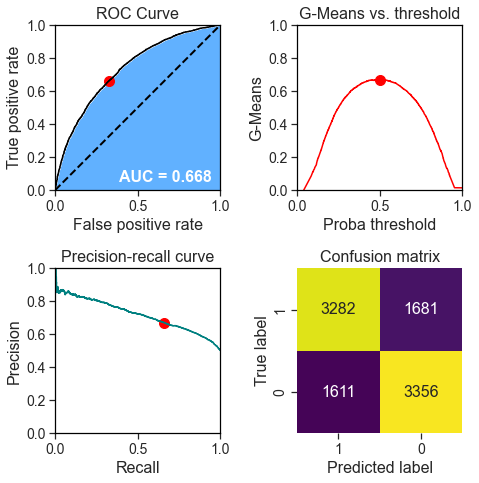

In [177]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics

model = grid.best_estimator_
model.fit(X_train_pca, y_train)

y_prob = model.predict_proba(X_test_pca)
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

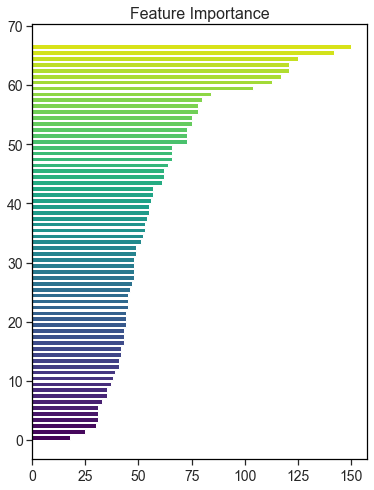

In [178]:
# Recover important features from previous fit and then permute importance
n_feat = 70  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6, 8))
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center', color=my_colors(70))
plt.title('Feature Importance')
plt.show()
